# Introduction
The U.S. has almost 500 students for every guidance counselor. Underserved youth lack the network to find their career role models, making CareerVillage.org the only option for millions of young people in America and around the globe with nowhere else to turn.

Our goal is to develop a method to recommend relevant questions to the professionals who are most likely to answer them.

First, Jared shared the following feedback from professionals:

* "These question don't really feel relevant to me."
* "I waited around but never got matched to anything."
* "I used to get the emails, but then they stopped."
* "This is way too much email. I get something like almost every day!"
* "If the questions were more relevant, I'd be willing to get emailed more often. But if they are not relevant, then I don't want much email at all."
* "The emails aren't that insightful, and don't show me enough info about the questions without having to click in" 

All these revolve around two main themes, **relevance of questions** and **frequency of receiving questions**. After looking at CareerVillage's current recommender system, I realize it mainly matches professionals to questions based on tags. Hence, I plan to:

* Introduce a recommender system that takes "questions" and "answers profile" into account using 4 different models as I will show how professionals have answered questions that not necessarily have `tags` they follow.
* Introduce a new notification setting. This allows professional to have daily or 3-day (or more) notification setting. The system is able to limit the number of emails sent to professional per day and also keep professionals who have not been receiving questions engaged with the platform.

I will also provide some future recommendations:
* Option to modify profile
* Three-day email notification
* Reducing spam by students
* "Shifting" questions
* Handling cold start by tags
* Keeping track of questions that are unanswered

# Table of Contents
1. EDA
2. Model construction
3. Evaluation
4. Future recommendations
5. Metadata
6. Meta-RecSys
7. Final Meta-RecSys
8. Conclusion
9. Final Thoughts
10. Closing remarks

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from time import time
import pandas as pd
import numpy as np 
import warnings; import random; import gensim; import re; import os; import gc

warnings.simplefilter('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn import preprocessing 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
stop = stopwords.words('english')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from __future__ import absolute_import, division, print_function
import tensorflow_hub as hub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


W0522 01:52:37.714383 139851990710144 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
PATH = '.'

questions = pd.read_csv(PATH + '/questions.csv.zip', compression='zip')
answers = pd.read_csv(PATH + '/answers.csv.zip', compression='zip')
matches = pd.read_csv(PATH + '/matches.csv.zip', compression='zip')
emails = pd.read_csv(PATH + '/emails.csv.zip', compression='zip')
professionals = pd.read_csv(PATH + '/professionals.csv.zip', compression='zip')
tags = pd.read_csv(PATH + '/tags.csv')
students = pd.read_csv(PATH + '/students.csv.zip', compression='zip')
tag_questions = pd.read_csv(PATH + '/tag_questions.csv.zip', compression='zip')
tag_users = pd.read_csv(PATH + '/tag_users.csv.zip', compression='zip')
question_scores = pd.read_csv(PATH + '/question_scores.csv')
answer_scores = pd.read_csv(PATH + '/answer_scores.csv.zip', compression='zip')

I create some handy functions here.

In [0]:
#################################
# Merging, stripping html, 
# get questions_id based on indices
#################################

def new_question_answers():
    try:
        del questions; gc.collect(); del answers; gc.collect()
    except:
        pass
    # read in questions and answers again
    questions = pd.read_csv(PATH+'/questions.csv.zip', compression='zip')
    answers = pd.read_csv(PATH+'/answers.csv.zip', compression='zip')
    
    return questions, answers

def merging(df1, df2, left, right):
    return df1.merge(df2, how="inner", left_on=left, right_on=right)    

# unfathomable pattern
noise = re.compile(r'http\S+|\d+|[\n\r]|www\S+|&lt;/span&gt;|&lt;span|style="background-color:|transparent;"&gt;|&nbsp;|&amp|http;')

def strip_html(s):
    return re.sub('<[^<]+?>', ' ', str(s))

def process_text(df, col):
    s = df[col].copy()
    s = s.apply(strip_html)
    s = s.str.replace(noise, ' ') # remove noise
    s = s.str.replace('[^\w\s\n\t]',' ') # replace punctuations
    s = s.str.replace('-',' ') # replace dashes
    s = s.str.replace('\\', '') # remove \
    s = s.str.replace('\d+','') # replacing digits
    s = s.str.lower().str.split() # convert all str to lowercase
    s = s.apply(lambda x: [item for item in x if item not in stop]) # remove stopwords
    s = s.apply(' '.join) # convert list to str
    return s

def get_question(q_id):
    return questions[questions['questions_id'] == q_id]['questions_body'].tolist()[0]

def similar_questions(q_id, dic, top_n=10):
    print("Current question: " + get_question(q_id))
    print('\n')
    print("Similar questions: ")
    etc = dic[q_id][1:top_n]
    for k, v in enumerate(etc):
        print(get_question(v[1]))
        print('\n')
        
def build_question_edges(df, cos_sim):
    question_edges = {}
    
    for idx, row in df.iterrows():
        similar_indices = cos_sim[idx].argsort()[:-20:-1]
        similar_items = [(cos_sim[idx][i],
                          df.iloc[i]['questions_id']) for i in similar_indices]
        question_edges[row['questions_id']] = similar_items[:20]
        
    return question_edges        

# 1. EDA
In addition to my first public [kernel](https://www.kaggle.com/wjshenggggg/update-5-text-processing) that has some EDA, I perform EDA on questions asked after 1/1/2018 - trying to understand when are questions and answers added as well as why some questions take longer response time.

In [0]:
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'])

answers['day_of_week'] = answers['answers_date_added'].dt.dayofweek

days_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed',
             3: 'Thu', 4: 'Fri', 5: 'Sat',
             6: 'Sun'}

dow_cnt = answers['day_of_week'].apply(lambda x: days_dict[x]).value_counts()

# df = answers.groupby(['answers_author_id', 'day_of_week'])['answers_id'].count().reset_index()

# val_cnt = df['day_of_week'].value_counts()

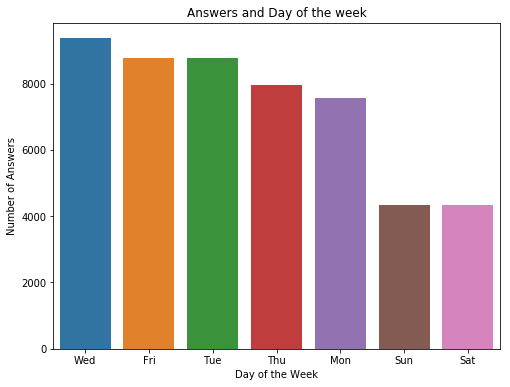

In [6]:
plt.figure(figsize=(8,6))
sns.barplot(dow_cnt.index,
            dow_cnt.values)
plt.title('Answers and Day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Answers')
plt.show()

In [0]:
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])

questions['day_of_week'] = questions['questions_date_added'].dt.dayofweek

dow_cnt = questions['day_of_week'].apply(lambda x: days_dict[x]).value_counts()

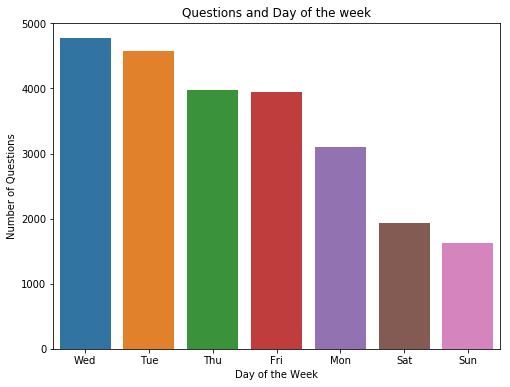

In [8]:
plt.figure(figsize=(8,6))
sns.barplot(dow_cnt.index,
            dow_cnt.values)
plt.title('Questions and Day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Questions')
plt.show()

Most questions and answers are added on Wednesday, with weekends having the lowest activity.

In the next section, I define slow response time as more than 7 days taken for the first answer to be added; fast response as 3 days of less; moderate as between slow and fast.

In [0]:
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])

questions['questions_date_added'] = pd.DatetimeIndex([i.replace(tzinfo=None) for i in questions['questions_date_added']])

questions = questions[questions['questions_date_added'] >= pd.datetime(2018, 1, 1)]

qa = merging(questions, answers, 'questions_id', 'answers_question_id')

qa['answers_date_added'] = pd.to_datetime(qa['answers_date_added'])

qa['answers_date_added'] = pd.DatetimeIndex([i.replace(tzinfo=None) for i in qa['answers_date_added']])

qa['resp_time'] = (qa['answers_date_added'] - qa['questions_date_added']).dt.days

qa = qa.sort_values('answers_date_added')

first_qa = qa.groupby('questions_id').head(1)

first_qa.shape # 7509

unanswered = questions[~questions['questions_id'].isin(answers['answers_question_id'].tolist())][['questions_id', 'questions_title', 'questions_body']]

In [26]:
slow = first_qa[first_qa['resp_time'] > 7][['questions_id', 'questions_title', 'questions_body']] # 3542 

slow_unanswered = pd.concat([slow, unanswered]) # 4334

fast = first_qa[first_qa['resp_time'] <= 3][['questions_id', 'questions_title', 'questions_body']] # 3504

moderate = first_qa[(first_qa['resp_time'] > 3) & (first_qa['resp_time'] <= 7)][['questions_id', 'questions_title', 'questions_body']] # 463

print('Number of questions that are answered within 3 days: {}'.format(fast.shape[0]))
print('Number of questions that are answered between 3 and 7 days: {}'.format(moderate.shape[0]))
print('Number of questions that are still unanswered or took more than 7 days to be answered: {}'.format(slow_unanswered.shape[0]))

Number of questions that are answered within 3 days: 3504
Number of questions that are answered between 3 and 7 days: 463
Number of questions that are still unanswered or took more than 7 days to be answered: 4334


In [0]:
fast_body = process_text(fast, 'questions_body')
slow_body = process_text(slow_unanswered, 'questions_body')

fast_dist = fast_body.apply(lambda x: len(x.split(' ')))
slow_dist = slow_body.apply(lambda x: len(x.split(' ')))

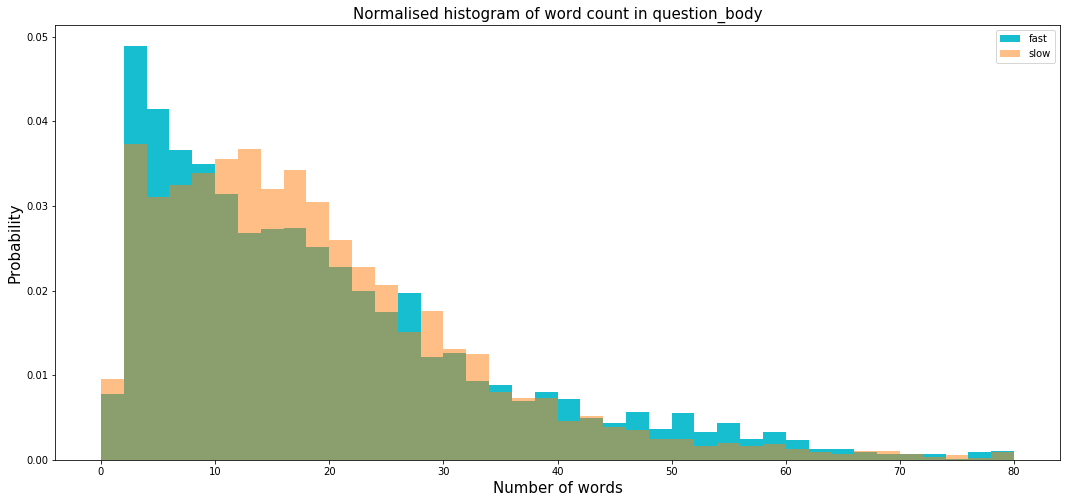

In [28]:
pal = sns.color_palette()
plt.figure(figsize=(18, 8))
plt.hist(fast_dist, bins=40, range=[0, 80], color=pal[9], normed=True, label='fast')
plt.hist(slow_dist, bins=40, range=[0, 80], color=pal[1], normed=True, alpha=0.5, label='slow')
plt.title('Normalised histogram of word count in question_body', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

As previously mentioned, questions that have a longer response time tend to be longer. We can perhaps solve this by targeting a larger audience in the RecSys.

In [0]:
#################################
# Create a tfidf matrix based on input
#################################

def get_tfidf_matrix(s):
    tfidf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,2),
                     min_df=3,
                     max_df=0.001,
                     stop_words='english')

    tfidf_matrix = tfidf.fit_transform(s)
    
    vocab = tfidf.get_feature_names()

    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    return cosine_sim, tfidf, vocab, tfidf_matrix

_, _, fast_vocab, fast_matrix = get_tfidf_matrix(fast_body)
_, _, slow_vocab, slow_matrix = get_tfidf_matrix(slow_body)

In [0]:
def word_score_pair(matrix, vocab, n=10, common=True):
    mat_to_arr = matrix.toarray() # convert the 2d matrix to a 2d array
    word_score = list(map(sum,zip(*mat_to_arr))) # fastest way to sum across all columns
    
    if common == True:
        rank_words_idx = np.argsort(word_score)[::-1]
    else:
        rank_words_idx = np.argsort(word_score)
        
    idx_list = rank_words_idx[:n]
    
    for idx in idx_list:
        print("word: {0}, score: {1:.3f}".format(vocab[idx], word_score[idx]))

In [31]:
word_score_pair(fast_matrix, fast_vocab)

word: collegestudent, score: 3.000
word: looking law, score: 3.000
word: asking questions, score: 3.000
word: premed medical, score: 3.000
word: techniques, score: 3.000
word: whats, score: 3.000
word: major social, score: 3.000
word: worthwhile, score: 3.000
word: summer school, score: 3.000
word: psychology counseling, score: 3.000


In [32]:
word_score_pair(slow_matrix, slow_vocab)

word: daca, score: 3.843
word: business major, score: 3.747
word: candidates, score: 3.707
word: leave college, score: 3.697
word: want internship, score: 3.697
word: transitioning, score: 3.697
word: instructional, score: 3.586
word: conduct, score: 3.577
word: work time, score: 3.520
word: fisheries, score: 3.496


In [33]:
word_score_pair(slow_matrix, slow_vocab, common=False)

word: australia school, score: 0.494
word: masters ecology, score: 0.494
word: masters europe, score: 0.494
word: usa want, score: 0.494
word: europe foreign, score: 0.494
word: germany accept, score: 0.494
word: scientific field, score: 0.494
word: science masters, score: 0.494
word: germany environmental, score: 0.494
word: living australia, score: 0.494


I explore the common and rare words in the `slow` response category. Surprisingly, the common words from `slow` are in fact common - I can tell that there will be relevant professionals who are able to answer those questions. On the other hand, the uncommon words from `slow` seem to be more specific to region as words such as "australia", "europe", and "germany" appear. 

# 2. Model construction
Four models will be deployed to generate the RecSys, namely TF-IDF FastText, GloVe, and Universal Sentence Encoder. The reason is all four approaches are able to capture various subtleties in a question. For instance, TF-IDF captures similarity between bigrams while FastText embedding allows similar semantics to be captured.

## TF-IDF 

In [0]:
#################################
# Create a tfidf matrix based on input
#################################

def get_tfidf_matrix(s):
    tfidf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,2),
                     min_df=3,
                     max_df=0.95,
                     stop_words='english')

    tfidf_matrix = tfidf.fit_transform(s)
    
    vocab = tfidf.get_feature_names()

    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    return cosine_sim, tfidf, vocab, tfidf_matrix

In [0]:
#################################
# Create common functions for embeddings
#################################

def generate_doc_vectors(s, embeddings_index, n):
    words = str(s).split() 
    M = []
    for w in words:
        if w in embeddings_index:
            M.append(embeddings_index[w])
    v = np.array(M).sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(n)
    return v / np.sqrt((v ** 2).sum())

def get_cos_sim(xtrain_embeddings):
    scl = preprocessing.StandardScaler()
    xtrain_embeddings = np.array(xtrain_embeddings)
    xtrain_embeddings = scl.fit_transform(xtrain_embeddings)

    cos_sim = linear_kernel(xtrain_embeddings, xtrain_embeddings)
    
    return cos_sim, scl

def get_emb_mat(s, *args):
    xtrain_embeddings = [generate_doc_vectors(x, *args) for x in s]

    cos_sim, scl = get_cos_sim(xtrain_embeddings)
    
    return cos_sim, scl, xtrain_embeddings

## FastText embedding

In [0]:
EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/careervillage/crawl-300d-2M.vec'

fembeddings_index = {}
f = open(EMBEDDING_FILE, encoding="utf8")
count = 0
for line in f:    
    count += 1
    if count == 500000: 
        break
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fembeddings_index[word] = coefs
f.close()

## GloVe

In [51]:
# os.chdir('/content')

answer_scores.csv.zip  groups.csv	      sample_data
answers.csv.zip        kaggle.json	      school_memberships.csv
comments.csv.zip       matches.csv.zip	      students.csv.zip
drive		       professionals.csv.zip  tag_questions.csv.zip
emails.csv.zip	       question_scores.csv    tags.csv
group_memberships.csv  questions.csv.zip      tag_users.csv.zip


In [0]:
EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/careervillage/glove.6B.50d.txt'

gembeddings_index = {}
f = open(EMBEDDING_FILE)
count = 0
for line in f:
    count += 1
    if count == 500000: 
        break
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    gembeddings_index[word] = coefs
f.close()

## Universal Sentence Encoder
Caveat: Running Universal Sentence Encoder takes a considerable amount of time. I will only run this twice to illustrate its "power" and leave out in the latter evaluation sections.

In [0]:
hub_embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

def get_use_matrix(s):
    embeddings = hub_embed(s)

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        xtrain_embeddings = session.run(embeddings)
        
    cos_sim, scl = get_cos_sim(xtrain_embeddings)
    
    return cos_sim, scl, xtrain_embeddings

# 3. Evaluation
## Evaluation Approach #1
The first approach to test our RecSys is by entering a query to get similar questions. Essentially, our model can be evaluated based on a query (entered manually) and check how similar is it to the questions recommended by the RecSys. I intend to make a note that CareerVillage can use this approach to recommend questions that have been answered in the past without necessarily recommending the query to the professionals.

In [0]:
#################################
# Functions to clean a query
# and get TF-IDF format
#################################

def generate_ngrams(text, N):
    grams = [text[i:i+N] for i in range(len(text)-N+1)]
    grams = [" ".join(b) for b in grams]
    return grams

def clean_query(text):
    text = strip_html(text)
    text = re.sub(r'[^\w\s|\n\t]',' ', text) # TODO \n
    text = text.lower()
    text = text.split(' ')
    text = [word for word in text if word not in stop]
    text = ' '.join(text)
    text = ' '.join(text.split()) # strip extra whitespace
    return text

def tokenize_clean_query(text):
    return clean_query(text).split(' ')

def get_tf_format_input(tokens):
    return generate_ngrams(tokens, 2) + generate_ngrams(tokens, 1)

def query_to_tokens(query):
    query_tokens = tokenize_clean_query(query)
    res = get_tf_format_input(query_tokens)
    return res

In [0]:
#################################
# Get indices of questions
#################################

def top_idx(query_score, mat):
    # dot with matrix to find similarity_score with embedding matrix
    query_cos_sim = cosine_similarity(query_score, mat)

    # get the top 10 scores in indices
    relevant_q_indices = np.argsort(query_cos_sim.flatten())[::-1][:10]
    
    return relevant_q_indices

def tf_relevant_q_indices(query, tfidf, tfidf_matrix):
    ngram_tokens = query_to_tokens(query)

    query_tf_score = tfidf.transform(ngram_tokens).toarray()

    query_score = np.mean(query_tf_score, axis=0).reshape(1, -1)
    
    return top_idx(query_score, tfidf_matrix)

def relevant_q_indices(query, embeddings_index, n, scl, emb):
    # clean the query
    query = clean_query(query)
    
    # get the score from embeddings
    query_score = generate_doc_vectors(query, embeddings_index, n).reshape(1,-1)
    
    # normalize query_score
    query_score = scl.transform(query_score)
    
    return top_idx(query_score, emb)

def use_relevant_q_indices(query, scl, emb):    
    query = clean_query(query)
    query_emb = hub_embed([query])

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        query_embeddings = session.run(query_emb)

    query_score = scl.transform(query_embeddings)
    
    return top_idx(query_score, emb)

I attempt to work with a smaller sample. Furthermore, after performing some EDA, I realize that some students asked their questions in `questions_title` and added some `hashtags` in the `questions_body`. In that case, `questions_body` might not reflect the **question** well. I try to concatenate the `questions_title` and `questions_body` to represent a **question**.

In [0]:
questions = questions[:1000]

questions['questions_title_body'] = questions['questions_title'] + \
                                    str(' ') + \
                                    questions['questions_body']

# clean the text
s = process_text(questions, 'questions_title_body').values 

In [0]:
query = 'i am intereted in data science and machine learning. do you have any tips for me?'

In [0]:
tfidf_cos_sim, tfidf, vocab, tfidf_matrix = get_tfidf_matrix(s)
t_q_indices = tf_relevant_q_indices(query, tfidf, tfidf_matrix)

fast_cos_sim, fscl, femb = get_emb_mat(s, fembeddings_index, 300)
f_q_indices = relevant_q_indices(query, fembeddings_index, 300, fscl, femb)

glove_cos_sim, gscl, gemb = get_emb_mat(s, gembeddings_index, 50)
g_q_indices = relevant_q_indices(query, gembeddings_index, 50, gscl, gemb)

use_cos_sim, uscl, uemb = get_use_matrix(s)
u_q_indices = use_relevant_q_indices(query, uscl, uemb)

In [53]:
t_q_indices, f_q_indices, g_q_indices, u_q_indices

(array([ 49, 831, 751, 847, 518, 488, 675,   9, 552, 592]),
 array([ 49,  46, 531, 488, 518, 416, 909, 351, 284, 398]),
 array([127, 651, 416,  46, 436, 297, 971,  49, 798, 199]),
 array([ 49,  46,  14,   4, 740, 284, 531, 894, 609, 260]))

Notice how all four models recommended different questions but there is still some overlap of indices of questions recommended.

A weight is then assigned to each question based on Borda count. `questions_id`that appears first has a weight of 1 and a decrement of 0.1 is applied to the subsequent `questions_id`, i.e., the second question has a weight of 0.9, third 0.8 and so on.

In [0]:
def build_q_occ(q_indices):
    d = {}
    for _q_indices in q_indices:
        score_weight = 1
        for idx in _q_indices:
            if idx in d:
                d[idx] += score_weight
            else:
                d[idx] = score_weight
            score_weight -= 0.1 # Borda count
    return sorted(d.items(), key=lambda kv: kv[1], reverse=True)

In [0]:
def print_questions(model, questions, q_indices, n=3):
    print('Recommedation by {} ...'.format(model))
    top_q_indices = q_indices[:n]
    cnt = 1
    for idx in top_q_indices:
        print(cnt)
        print(questions.iloc[idx]['questions_title'])
        print(questions.iloc[idx]['questions_body'][:100])
        if cnt == 3:
            break
        print('\n')
        cnt += 1
    print('-----')

In [56]:
print_questions('TF-IDF', questions, t_q_indices)
print_questions('FastText', questions, f_q_indices)
print_questions('GloVe', questions, g_q_indices)
print_questions('Universal Sentence Encoder', questions, u_q_indices)

Recommedation by TF-IDF ...
1
What is the difference between data science and machine learning?
I've been looking into data science careers, and I know that it is closely related with machine lear


2
How did you complete a science college degree as an adult?
I am pursuing a science degree after taking a few years away from school.  Knowing science and math 


3
How to make your mind more creative?
#creativity #learning #mental-exercise #creative #learning 
-----
Recommedation by FastText ...
1
What is the difference between data science and machine learning?
I've been looking into data science careers, and I know that it is closely related with machine lear


2
Best resources for developing in Information Security?
Such as resources for learning specific programming/scripting languages (Python, Perl, bash), sites 


3
Which program is best to start learning coding?
I want to learn to code. Should I start with python, Java, etc. ?
#coding 
#computer-science 
-----
Recommedation by GloV

Combining all four models, we come up with the recommended questions below.

In [57]:
q_indices = (t_q_indices, f_q_indices, g_q_indices, u_q_indices)
top_3_q_indices = build_q_occ(q_indices)[:3]

print('All 4 models\' recommendation')
rec_q_indices = top_3_q_indices
for idx_score in rec_q_indices:
    print(questions.iloc[idx_score[0]]['questions_title'])
    print(questions.iloc[idx_score[0]]['questions_body'][:100])
    print('\n')    

All 4 models' recommendation
What is the difference between data science and machine learning?
I've been looking into data science careers, and I know that it is closely related with machine lear


Best resources for developing in Information Security?
Such as resources for learning specific programming/scripting languages (Python, Perl, bash), sites 


What is the best coding language to know to become a computer programer?
#computer #computer-engineering #computer-programming #coding 




## Evaluation Approach #2
Clearly, the RecSys can then recommend professionals based on professionals who have answered the similar questions shown above. But I think the RecSys should be able to further improve its recommendation if each professional has its own `profile`. My motivation of coming with this approach is `questions_body` or `questions_title` might not reflect the essence of the questions but answers can. I attempt to construct a profile for professionals based on what `vocab` best describes them. Given a query, the RecSys can recommend relevant professionals based on their historical answers, again building upon the four models. 

In [0]:
#################################
# Get indices of professionals and
# build professionals' profiles
#################################

def get_q_id(questions, idx):
    return questions.iloc[idx]['questions_id']

def get_p_ids(qa, q_id):
    # returns a list of professional_ids who
    # have answered that question
    return qa[qa['questions_id'] == q_id]['answers_author_id'].tolist()

def p_profiles(p_ids, qa, mat):
    all_scores = []
    for p_id in p_ids:
        p_avg_score = p_profile(p_id, qa, mat)
        all_scores.append(p_avg_score)        
    return all_scores    

def p_profile(p_id, qa, mat):
    l = qa[qa['answers_author_id'] == p_id].index
    scores = []
    
    for idx in l:
        try:
            scores.append(mat[idx].toarray().flatten())
        except:
            scores.append(mat[idx].flatten())
                        
    scores = np.asarray(scores)
    scores = np.mean(scores, axis=0)
    return scores

def get_p_relevant_words(scores, ans_vocab, top_n=10):
    scores_idx = np.argsort(scores)[::-1][:top_n]

    vocab = []
    score = []
    
    for idx in scores_idx:
        vocab.append(ans_vocab[idx])
        score.append(scores[idx])
    
    vocab_score_df = pd.DataFrame({'vocab': vocab,
                                   'score': score})
    
    return vocab_score_df

In [0]:
#################################
# Returns the indices of 10 closest professionals 
# to a query based on professionals' profiles
#################################

def t_relevant_p_indices(query, ans_tf, p_scores_matrix):
    ngram_tokens = query_to_tokens(query)

    query_tf_score = ans_tf.transform(ngram_tokens).toarray()

    query_score = np.mean(query_tf_score, axis=0).reshape(1, -1)
    
    return top_idx(query_score, p_scores_matrix)

def relevant_p_indices(query, embeddings_index, n, scl, p_scores_matrix):
    # clean the query
    query = clean_query(query)
    
    # get the score from embeddings
    query_score = generate_doc_vectors(query, embeddings_index, n).reshape(1,-1)
    
    # normalize query_score
    query_score = scl.transform(query_score)
    
    return top_idx(query_score, p_scores_matrix)

def u_relevant_p_indices(query, scl, p_scores_matrix):    
    query = clean_query(query)
    query_emb = hub_embed([query])

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        query_embeddings = session.run(query_emb)

    query_score = scl.transform(query_embeddings)
    
    return top_idx(query_score, p_scores_matrix)

In [0]:
qa = merging(questions, answers, 'questions_id', 'answers_question_id')

# clean answers_body
ans = process_text(qa, 'answers_body').values

# create a list of professionals_ids
p_ids = qa['answers_author_id'].unique().tolist()

I start with constructing a profile for each professional using four different models.

In [0]:
# Building profiles
_, ans_tf, ans_vocab, ans_tfidf_matrix = get_tfidf_matrix(ans)
t_p_scores = np.asarray(p_profiles(p_ids, qa, ans_tfidf_matrix))
t_p_indices = t_relevant_p_indices(query, ans_tf, t_p_scores)

_, fans_scl, fans_emb = get_emb_mat(ans, fembeddings_index, 300)
f_p_scores = np.asarray(p_profiles(p_ids, qa, fans_emb))
f_p_indices = relevant_p_indices(query, fembeddings_index, 300, fans_scl, f_p_scores)

_, gans_scl, gans_emb = get_emb_mat(ans, gembeddings_index, 50)
g_p_scores = np.asarray(p_profiles(p_ids, qa, gans_emb))
g_p_indices = relevant_p_indices(query, gembeddings_index, 50, gans_scl, g_p_scores)

_, uans_scl, uans_emb = get_use_matrix(ans)
u_p_scores = np.asarray(p_profiles(p_ids, qa, uans_emb))
u_p_indices = u_relevant_p_indices(query, uans_scl, u_p_scores)

In [0]:
def build_p_occ(p_indices):
    d = {}
    for _p_indices in p_indices:
        score_weight = 1   
        for i in _p_indices:
            p = p_ids[i]
            if p in d:
                d[p] += score_weight
            else:
                d[p] = score_weight
            score_weight -= 0.1

    return sorted(d.items(), key=lambda kv: kv[1], reverse=True)

Combining profiles built by all four models, the recommended professionals are as follows.

In [63]:
p_indices = (t_p_indices, f_p_indices, g_p_indices, u_p_indices)
top_3_p_indices = build_p_occ(p_indices)[:3] 

for pid_score in top_3_p_indices:
    print('professional_id: {}'.format(pid_score[0]))
    p_headline = professionals[professionals['professionals_id'] == pid_score[0]]\
                                ['professionals_headline'].to_string()
    print('Headline: {}'.format(p_headline))    
    print('\n')

professional_id: 3daa962dd713439eaf6df9e2966d9514
Headline: 17859    Student at California State University-Los Ang...


professional_id: 3ea0910f146e4bc1b0da625d49da320c
Headline: 8037    Business Intelligence Manager


professional_id: 2801dfbdd5914b65b3369ff3385bc16b
Headline: 20402    Now available!All-rounder Mechanical Engineer ...




## Evaluation Approach #3
When recommending questions to professionals, the final RecSys accounts for 
1. the similarity between query and other questions;
2. the similarity between query and professionals' profiles (containing `vocab` and `score`) based on their historical answers.

Now, Borda count is applied to the `professionals_id` based on the order they were suggested to construct our final dictionary `p_counts`, which consists of  `professionals_id` and `score_weight`. In order words, the RecSys includes professionals who have answered similar questions in the past and professionals who have profiles (historical answers) similar to the incoming query.

In [0]:
#################################
# Returns the ranking of professionals
# from Approach 1 and Approach 2
#################################

def p_rank(questions, qa, q_indices, p_indices, n=5):
    p_counts = {}

    for _q_indices in q_indices:
        score_weight = 1
        for i in _q_indices:
            for p in get_p_ids(qa, get_q_id(questions, i)):
                if p in p_counts:
                    p_counts[p] += score_weight
                else:
                    p_counts[p] = score_weight
            score_weight -= 0.1        
            
    for _p_indices in p_indices:
        score_weight = 1   
        for i in _p_indices:
            p = p_ids[i]
            if p in p_counts:
                p_counts[p] += score_weight
            else:
                p_counts[p] = score_weight
            score_weight -= 0.1
        
    p_counts = sorted(p_counts.items(), key=lambda kv: kv[1], reverse=True)[:n]
    return [p_count[0] for p_count in p_counts]

Based on the `p_count`, the RecSys now recommends the professionals based on the ranking and show the words most relevant to the professionals. 

In [0]:
#################################
# Recommend top 5 professionals
# with their vocab_score 
#################################

def who_to_rec(p_counts, professionals, qa, ans_vocab, ans_tfidf_matrix):        
    count = 1
    for p in p_counts[:3]:
        print('Recommending rank {} professional'.format(count))

        print('Headline: {}'.format(professionals[professionals['professionals_id'] == p]\
                                    ['professionals_headline'].tolist()[0]))

        print('Top 3 highest scores words:')

        p_scores = p_profile(p, qa, ans_tfidf_matrix)

        print(get_p_relevant_words(p_scores, ans_vocab, 3))

        print('\n')

        count += 1

In [66]:
who_to_rec(p_rank(questions, qa, q_indices, p_indices), professionals, qa, ans_vocab, ans_tfidf_matrix)

Recommending rank 1 professional
Headline: Student at California State University-Los Angeles
Top 3 highest scores words:
        vocab     score
0  algorithms  0.487712
1        data  0.478284
2    includes  0.390998


Recommending rank 2 professional
Headline: Business Intelligence Manager
Top 3 highest scores words:
              vocab     score
0  machine learning  0.422301
1      data science  0.414403
2           machine  0.400947


Recommending rank 3 professional
Headline: Data Scientist at Airbnb
Top 3 highest scores words:
              vocab     score
0          requires  0.277327
1  machine learning  0.261464
2           problem  0.256825




Notice how professionals recommended in Evaluation Approach #2 in `top_3_p_indices` are slightly different compared to Evaluation Approach #3 in `who_to_rec`.

Below, I added the functions to build and run the RecSys. As mentioned earlier, the Universal Sentence Encoder will be left out to speed up the process.

In [0]:
#################################
# Add a function to "streamline" 
# all the functions with just a query
# returns a list of top 5 professionals
#################################

def build_RecSys(s, ans, qa, p_ids):    
    
    #################################
    # questions similarity
    #################################
    _, tfidf, vocab, tfidf_matrix = get_tfidf_matrix(s)
    _, fscl, femb = get_emb_mat(s, fembeddings_index, 300)
    _, gscl, gemb = get_emb_mat(s, gembeddings_index, 50)
    # _, uscl, uemb = get_use_matrix(s) 

    #################################
    # professionals' profile
    #################################
    _, ans_tf, ans_vocab, ans_tfidf_matrix = get_tfidf_matrix(ans)
    _, fans_scl, fans_emb = get_emb_mat(ans, fembeddings_index, 300)
    _, gans_scl, gans_emb = get_emb_mat(ans, gembeddings_index, 50)
    # _, uans_scl, uans_emb = get_use_matrix(ans)
    
    t_p_scores = np.asarray(p_profiles(p_ids, qa, ans_tfidf_matrix))
    f_p_scores = np.asarray(p_profiles(p_ids, qa, fans_emb))
    g_p_scores = np.asarray(p_profiles(p_ids, qa, gans_emb))
    # u_p_scores = np.asarray(p_profiles(p_ids, qa, uans_emb))

    return tfidf, tfidf_matrix, fscl, femb, gscl, gemb, ans_tf, fans_scl, gans_scl, t_p_scores, f_p_scores, g_p_scores, vocab

    
def run_RecSys(query, questions, qa, n, tfidf, tfidf_matrix, fscl, femb, gscl, gemb, ans_tf, fans_scl, gans_scl, t_p_scores, f_p_scores, g_p_scores):
    
    #################################
    # questions similarity
    #################################
    
    t_q_indices = tf_relevant_q_indices(query, tfidf, tfidf_matrix)
    f_q_indices = relevant_q_indices(query, fembeddings_index, 300, fscl, femb)
    g_q_indices = relevant_q_indices(query, gembeddings_index, 50, gscl, gemb)
    # u_q_indices = use_relevant_q_indices(query, uscl, uemb)
    
    q_indices = (t_q_indices, f_q_indices, g_q_indices)
    
    #################################
    # professionals' profile
    #################################
    
    t_p_indices = t_relevant_p_indices(query, ans_tf, t_p_scores)
    f_p_indices = relevant_p_indices(query, fembeddings_index, 300, fans_scl, f_p_scores)
    g_p_indices = relevant_p_indices(query, gembeddings_index, 50, gans_scl, g_p_scores)
    # u_p_indices = u_relevant_p_indices(query, uans_scl, u_p_scores)
    
    p_indices = (t_p_indices, f_p_indices, g_p_indices)
    
    combined_p_rank = p_rank(questions, qa, q_indices, p_indices, n)
    
    return combined_p_rank

## Evaluation Approach #4
It is now time to answer the question: will the RecSys be performing better than CareerVillage's current RecSys? Before diving into the approach, let's explore questions that have been recommended by CareerVillage with some EDA. The `professionals` dataset has a total of 28,152 professionals registered but EDA shows that < 1,000 remain active.

I would like to extend my gratitude to RodH for coming up with the following approach of filtering emails received and questions answered by emails.

In [0]:
match_email = merging(matches, emails, 'matches_email_id', 'emails_id')

p_match_emails = match_email.groupby('emails_recipient_id').count()

p_match_emails = pd.DataFrame(p_match_emails['matches_email_id'].copy()).reset_index()

# p_match_emails.head()

p_emails = merging(professionals, emails, 'professionals_id', 'emails_recipient_id')

# p_emails.head()

p_received_emails = p_emails.groupby('emails_recipient_id').count()

p_received_emails = pd.DataFrame(p_received_emails['professionals_id'].copy()).reset_index()

# p_received_emails.head()

p_ans = answers.groupby('answers_author_id').count()

p_ans_cnt = pd.DataFrame(p_ans['answers_id'].copy()).reset_index()

In [69]:
p_received_match = merging(p_match_emails, p_received_emails, 'emails_recipient_id', 'emails_recipient_id')

p_received_match_ans = merging(p_received_match, p_ans_cnt, 'emails_recipient_id', 'answers_author_id')

p_received_match_ans.drop('answers_author_id', axis=1, inplace=True)

p_received_match_ans = p_received_match_ans.rename(columns={"matches_email_id": "emails_received", 
                                                             "professionals_id": "questions_received",
                                                             "answers_id": "questions_answered"})

p_received_match_ans.head()

,emails_recipient_id,emails_received,questions_received,questions_answered
0,00009a0f9bda43eba47104e9ac62aff5,15,14,3
1,000d4635e5da41e3bfd83677ee11dda4,2335,945,3
2,00271cc10e0245fba4a35e76e669c281,41,19,24
3,0046ab8089c04b3a8df3f8c28621a818,4,3,5
4,0053becb71d94164b014a5a7d9673210,247,117,2


In [70]:
p_received_match_ans['pct'] = p_received_match_ans['questions_answered'] / p_received_match_ans['questions_received'] 

p_received_match_ans['pct'].describe()

count    8623.000000
mean        0.280648
std         1.403672
min         0.000511
25%         0.016393
50%         0.051136
75%         0.190476
max        83.181818
Name: pct, dtype: float64

In [0]:
questions, answers = new_question_answers()
qa = merging(questions, answers, 'questions_id', 'answers_question_id')

Apparently, professionals in the 75% percentile and above have a response rate of close to 20%.

Before I select a professional to conduct a further analysis, I intend to look for some professionals who have good track record, i.e., those who answered more than 20 questions and has an average response time of less than 5 days.

In [0]:
questions, answers = new_question_answers()
qa = merging(questions, answers, 'questions_id', 'answers_question_id')

qa['answers_date_added'] = pd.to_datetime(qa['answers_date_added'])
qa['answers_date_added'] = pd.DatetimeIndex([i.replace(tzinfo=None) for i in qa['answers_date_added']])

qa['questions_date_added'] = pd.to_datetime(qa['questions_date_added'])
qa['questions_date_added'] = pd.DatetimeIndex([i.replace(tzinfo=None) for i in qa['questions_date_added']])

qa['resp_time'] = (qa['answers_date_added'] - qa['questions_date_added']).dt.days

In [75]:
qa['cnt'] = 1
p_cnt = qa.groupby('answers_author_id')['cnt'].sum()
p_cnti = p_cnt[p_cnt > 20].index
p_cnti = p_cnti.tolist()

p_resp_time = qa.groupby('answers_author_id')['resp_time'].mean()
p_resp_timei = p_resp_time[p_resp_time < 5].index
p_resp_timei = p_resp_timei.tolist()

its = list(set(p_cnti).intersection(set(p_resp_timei)))

print('Number of professionals who answered more than 20 questions and have an average response time of less than 5 days: {}'.format(len(its)))

Number of professionals who answered more than 20 questions and have an average response time of less than 5 days: 11


Unfortunately, there are only 11 professionals who meet both criteria. Nevertheless, this is sufficient for me to conduct an analysis. In the section below, I will show both successful and failed cases of the RecSys.

In [0]:
SUCCESS_P_ID = '96bbbdd06a334805a0501034d9df1aa4' 
FAILED_P_ID = '7667c23d26ab409ca3e49758f5367925'

In [0]:
#################################
# For a given professional,
# check how many questions have been suggested by CV
# and how many of them have been answered
#################################

def suggest_vs_ans(TEST_P_ID):
    print('Professional\'s headline: {}\n'.format(professionals[professionals['professionals_id'] == TEST_P_ID]\
                                                ['professionals_headline'].tolist()[0]))
    
    p_emails_TEST = p_emails[p_emails['professionals_id'] == TEST_P_ID] # 27

    df = merging(p_emails_TEST, match_email, 'emails_id', 'matches_email_id')

    q_suggested = df['matches_question_id'].tolist()

    q_suggested_l = questions[questions['questions_id'].isin(q_suggested)]

    q_answered_l = qa[qa['answers_author_id'] == TEST_P_ID]

    print('CareerVillage suggested {} questions'.format(q_suggested_l.shape[0]))
    print('Professional answered {} questions'.format(q_answered_l.shape[0]))

    overlap = set(q_suggested_l['questions_id'].tolist()).intersection(set(q_answered_l['questions_id'].tolist()))

    print('{} question(s) suggested were answered'.format(len(overlap)))
    
    return q_suggested_l, q_answered_l

#################################
# Create a TEST_qa which includes 
# TEST_P_ID's answers in a period
# and validate result with VALID_qa
#################################

def test_valid_split(TEST_P_ID, dates):
    
    TEST_start, TEST_end, VALID_start, VALID_end = dates
    
    TEST_qa = qa[(qa['answers_date_added'] >= TEST_start) &
                 (qa['answers_date_added'] < TEST_end)].reset_index()

    VALID_qa = qa[(qa['answers_date_added'] >= VALID_start) &
                  (qa['answers_date_added'] < VALID_end)].reset_index()
    

    TEST_qa_p = TEST_qa[TEST_qa['answers_author_id'] == TEST_P_ID].drop_duplicates(subset=['questions_id'])

    VALID_qa = VALID_qa[VALID_qa['answers_author_id'] == TEST_P_ID].drop_duplicates(subset=['questions_id'])
    
    print('TEST_P_ID has {0} out of {1} entries in TEST_qa'.format(TEST_qa_p.shape[0], TEST_qa.shape[0]))
    print('TEST_P_ID has {0} entries in VALID_qa'.format(VALID_qa.shape[0]))
    
    return TEST_qa, VALID_qa

#################################
# For each question in VALID_qa,
# check whether will the question
# be recommended by TF-IDF
#################################

def calc_hit_rate(correct_idx, VALID_qa, TEST_ans_tf, TEST_t_p_scores):
    VALID_qa['questions_title_body'] = VALID_qa['questions_title'] + \
                                       str(' ') + \
                                       VALID_qa['questions_body']
    
    len_VALID_qa = VALID_qa.shape[0]
    
    hit_rate = 0

    for k, v in VALID_qa.iterrows():
        query = v['questions_title_body']

        t_p_indices = list(t_relevant_p_indices(query, TEST_ans_tf, TEST_t_p_scores))

        if correct_idx in t_p_indices:
            hit_rate += 1

    success_rate = hit_rate / len_VALID_qa * 100
    
    print('Success rate of RecSys out of {} questions is {:.1f}%.'.format(len_VALID_qa, (success_rate)))

#################################
# Get examples of questions suggested
# by CV and questions answered by TEST_P_ID
#################################

def print_egs(q_suggested_l, q_answered_l, n=5):
    print('Examples of questions suggested by CV:')
    cnt = 1
    for q_eg in q_suggested_l.sort_values('questions_date_added')['questions_title'].tolist()[:n]:
        print('{0}. {1}'.format(cnt, q_eg))
        cnt += 1

    cnt = 1
    print('\nExamples of questions answered by TEST_P_ID:')
    for q_eg in q_answered_l.sort_values('answers_date_added')['questions_title'].tolist()[:n]:
        print('{0}. {1}'.format(cnt, q_eg))
        cnt += 1

In [78]:
q_suggested_l, q_answered_l = suggest_vs_ans(FAILED_P_ID)

Professional's headline: Commercial Sales at Dell

CareerVillage suggested 99 questions
Professional answered 71 questions
0 question(s) suggested were answered


Interestingly, the professionals answered 71 questions, none of which has been suggested by CareerVillage. Why is this the case?

In [79]:
print_egs(q_suggested_l, q_answered_l)

Examples of questions suggested by CV:
1. On average how much does someone with a Computer Science degree make right out of school?
2. information technology or computer science which of these hard in math?
3. why do you like technology and try programing a computer?
4. I'm interested in a career in information technology. Are there jobs in aviation you suggest I look into?
5. What subjects are required for computer programming and computer engineering  and what jobs will you get with those careers?

Examples of questions answered by TEST_P_ID:
1. Should I live on campus or should I save money by living in an apartment around the town or city of the university?
2. In what ways is technology utilized by doctors?
3. what are some of the requirements to becoming a radiology tech
4. what courses are affiliated with a major in marketing?
5. What is the best college to attend to play football.


As seen above, the questions suggested were in fact, **relevant** to the professional's expertise, which revolves around computer science and IT. But the questions answered by `TEST_P_ID` are somewhat different from his or her expertise, including questions about doctor, radiology, and football.

Below, I will separate the `qa` into two sections: `TEST_qa`, which includes `qa` before 2016-5-20 and `VALID_qa`, which includes `qa` after 2016-5-20. I will build the `professional_profiles` on the `TEST_qa` and validate the results on `VALID_qa`.

In [80]:
FAILED_dates = [pd.datetime(2016,5,1), pd.datetime(2016,5,20), pd.datetime(2016,5,20), pd.datetime(2016,5,30)] # failed
TEST_qa, VALID_qa = test_valid_split(FAILED_P_ID, FAILED_dates)

TEST_P_ID has 48 out of 2387 entries in TEST_qa
TEST_P_ID has 22 entries in VALID_qa


In [0]:
# Building profiles for all professionals in the given period
TEST_p_ids = TEST_qa['answers_author_id'].unique().tolist()

TEST_ans = process_text(TEST_qa, 'answers_body')

_, TEST_ans_tf, TEST_ans_vocab, TEST_ans_tfidf_matrix = get_tfidf_matrix(TEST_ans)
TEST_t_p_scores = np.asarray(p_profiles(TEST_p_ids, TEST_qa, TEST_ans_tfidf_matrix))

In [82]:
# Get relevant words for TEST_P_ID
TEST_p_scores = p_profile(FAILED_P_ID, TEST_qa, TEST_ans_tfidf_matrix)

get_p_relevant_words(TEST_p_scores, TEST_ans_vocab)

,vocab,score
0,work,0.032170
1,scholarship,0.029565
2,school,0.029484
3,minor,0.027157
4,good,0.026003
5,networking,0.024611
6,want,0.023531
7,good luck,0.023390
8,yes,0.022994
9,english,0.022666


Unsurprisingly, the `vocab` that describes `TEST_P_ID` is too varied. Let's see the results from RecSys, I start by ignoring the cold start problem first (I will propose a solution to deal with cold start later) and build a `profile` for `TEST_P_ID` based on 48 questions answered. By calling `calc_hit_rate`, it will return how many of the questions answered by `TEST_P_ID` would be suggested by the RecSys.

In [83]:
calc_hit_rate(TEST_p_ids.index(FAILED_P_ID), VALID_qa, TEST_ans_tf, TEST_t_p_scores)

Success rate of RecSys out of 22 questions is 4.5%.


Our RecSys only recommend 1 question that has been answered by `TEST_P_ID`. 

This might be due to some reasons. I speculate that when professionals log onto careervillage.org, the landing page is not personalized to the professionals' expertise. They end up answering some random questions. I suppose a solution to this issue is to personalize the landing page apart from sending targeted emails. 

Let's explore a (partly) successful case of the RecSys.

In [84]:
q_suggested_l, q_answered_l = suggest_vs_ans(SUCCESS_P_ID)

Professional's headline: Experienced Higher Educational Professional & Certified Appreciative Advisor

CareerVillage suggested 120 questions
Professional answered 86 questions
15 question(s) suggested were answered


This professional has been doing pretty well, answered 15 out of the 120 questions suggested by CareerVillage! Let's take a look at the some examples of the questions suggested by CareerVillage and answered by `TEST_P_ID`.

In [85]:
print_egs(q_suggested_l, q_answered_l, 6)

Examples of questions suggested by CV:
1. Is it acceptable to pursue a STEM major at a liberal arts college?
2. What do college directors look at?
3. What's the difference between co-ed and all women's?
4. Does anyone know about the academic/social environment at Harvard University?
5. Should I double major if I want to go into music education?
6. What classes are good to take in college to be a riding instructor?

Examples of questions answered by TEST_P_ID:
1. Should i try different jobs that are completely unrelated to my degree or go and find one that i really wanted?
2. i would like to know the job opportunities for an IT student?
3. Is it acceptable to pursue a STEM major at a liberal arts college?
4. Best college to become a veterinarian?
5. I want to study aeronautic enginering bt i m biology student ,so can i study it ?
6. What do college directors look at?


The question "Is it acceptable to pursue a STEM major at a liberal arts college?" has been suggested and answered by `TEST_P_ID`. Overall, suggested questions and questions answered are in line - they relate to `TEST_P_ID`. 

Below, I will separate the `qa` into two sections: `TEST_qa`, which includes `qa` before 2016-3-7 and `VALID_qa`, which includes `qa` after 2016-3-7. I will build the `professional_profiles` on the `TEST_qa` and validate the results on `VALID_qa`.

In [86]:
SUCCESS_dates = [pd.datetime(2016,12,1), pd.datetime(2017,3,7), pd.datetime(2017,3,7), pd.datetime(2017,3,9)] # success
TEST_qa, VALID_qa = test_valid_split(SUCCESS_P_ID, SUCCESS_dates)

TEST_P_ID has 11 out of 2819 entries in TEST_qa
TEST_P_ID has 6 entries in VALID_qa


In [0]:
# Building profiles for all professionals in the given period
TEST_p_ids = TEST_qa['answers_author_id'].unique().tolist()

TEST_ans = process_text(TEST_qa, 'answers_body')

_, TEST_ans_tf, TEST_ans_vocab, TEST_ans_tfidf_matrix = get_tfidf_matrix(TEST_ans)
TEST_t_p_scores = np.asarray(p_profiles(TEST_p_ids, TEST_qa, TEST_ans_tfidf_matrix))

In [88]:
# Get relevant words for TEST_P_ID
TEST_p_scores = p_profile(SUCCESS_P_ID, TEST_qa, TEST_ans_tfidf_matrix)

get_p_relevant_words(TEST_p_scores, TEST_ans_vocab)

,vocab,score
0,school,0.064186
1,thanks question,0.063406
2,thanks,0.059343
3,question,0.052838
4,labor,0.047436
5,labor statistics,0.041809
6,bureau labor,0.041466
7,gpa,0.041452
8,hi,0.041349
9,veterinary,0.040397


In [89]:
calc_hit_rate(TEST_p_ids.index(SUCCESS_P_ID), VALID_qa, TEST_ans_tf, TEST_t_p_scores)

Success rate of RecSys out of 6 questions is 16.7%.


The RecSys managed to recommend 1 out of the 6 questions answered by `TEST_P_ID` and the question - "What do college directors look at?" was not suggested by CareerVillage but suggested by the RecSys. Even though the `vocab_score` does not give a indication of `TEST_P_ID`'s expertise (due to cold start problem since we only builed the profile on 11 questions), it is still an improvement!

# 4. Future recommendations
## Recommendation #1: Option to modify profile
Although I am building a RecSys that helps to recommend relevant questions to professionals, I am thinking of having professionals to improve the RecSys. This approach is especially useful when a professional intends to answer questions he or she is interested in. For instance, the IT professional above could be interested in and have some knowledge about "marketing" or have experiences in the role in the past.

I suggest adding the option of allowing professionals to "update" their profile. After displaying the `vocab_score`, professionals are given the option to weigh certain word that they think describe themselves better or words they are more interested in answering heavier. This recommendation could also help resolve the issue we had in Evaluation Approach #4 when professionals have been answering questions not quite related to their expertise.

I will illustrate this idea with only the TF-IDF model to speed things up.

In [0]:
def vocab_scores_update(scores, vocab_score_df, indices, ans_vocab, top_n=10):
    new_weight = 0.5 / len(indices) 

    scores_idx = np.argsort(scores)[::-1][:top_n]
    
    total_scores = sum(scores)
                    
    for idx in indices: 
        original_weight = scores[scores_idx[idx]] / total_scores
        scores[scores_idx[idx]] = new_weight * scores[scores_idx[idx]] / original_weight
        
    return scores

First, enter a query to see who are the professionals being suggested.

In [0]:
query = 'i am interested in pursuing a career in professional football. i enjoy playing football as a kid and want to be in the nfl'

In [0]:
questions, answers = new_question_answers()

questions = questions[:1000]
qa = merging(questions, answers, 'questions_id', 'answers_question_id')

# clean answers_body
ans = process_text(qa, 'answers_body').values

# create a list of professionals_ids
p_ids = qa['answers_author_id'].unique().tolist()

In [93]:
_, ans_tf, ans_vocab, ans_tfidf_matrix = get_tfidf_matrix(ans)
t_p_scores = np.asarray(p_profiles(p_ids, qa, ans_tfidf_matrix))

t_p_indices = t_relevant_p_indices(query, ans_tf, t_p_scores)

ps = [p_ids[pid] for pid in t_p_indices][:5]

print('Top 5 relevant professionals:')
ps

Top 5 relevant professionals:


['d7576ac17e9542ffb3935457c6a71c76',
 '0d134d3f07a2408a88983d9069c625e6',
 '6acc953bfe9549cfb3ffd6642b5a7f1c',
 'f3cec1b7b77a428ab7f71a39557ea741',
 'a7bf251a290b418e923e8f04a67b7ebb']

In [94]:
professionals[professionals['professionals_id'].isin(ps)]

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
2449,d7576ac17e9542ffb3935457c6a71c76,"Wilmington, Delaware",Nonprofit Organization Management,Senior Sports Director YMCA,2015-11-01 18:19:14 UTC+0000
6900,6acc953bfe9549cfb3ffd6642b5a7f1c,"Romford, England, United Kingdom",Information Technology and Services,Principal Architect - IC&C,2016-05-26 09:03:55 UTC+0000
7733,0d134d3f07a2408a88983d9069c625e6,"Albuquerque, New Mexico",Broadcast Media,Media Relations Director/Event Coordinator at ...,2016-08-17 19:04:54 UTC+0000
22789,f3cec1b7b77a428ab7f71a39557ea741,"Missoula, Montana",Telecommunications,Senior Vendor Manager,2018-09-04 18:24:14 UTC+0000
24454,a7bf251a290b418e923e8f04a67b7ebb,"Seattle, Washington",Software engineering,Software Development Engineer,2018-10-23 04:15:44 UTC+0000


From the recommendation above, observe that 5 professionals have been recommended in that order. Given the option to "update" the score, I try to show that if `0d134d3f07a2408a88983d9069c625e6` were to update his or her profile, the RecSys will suggest `0d134d3f07a2408a88983d9069c625e6` as the first choice. Notice that `0d134d3f07a2408a88983d9069c625e6` is from the broadcast media industry but perhaps, is knowledeable about football.

Let's see the `vocab` and `score` for this professional.

In [95]:
TEST_P_ID = '0d134d3f07a2408a88983d9069c625e6'

TEST_P_SCORES = p_profile(TEST_P_ID, qa, ans_tfidf_matrix)    

score_profile = get_p_relevant_words(TEST_P_SCORES, ans_vocab) 

score_profile

,vocab,score
0,athletics,0.280136
1,sports,0.265478
2,making connections,0.253399
3,connections,0.186775
4,department,0.175040
5,nfl,0.140068
6,sure ask,0.140068
7,administration college,0.140068
8,information director,0.140068
9,professional sports,0.140068


Now assume that he or she intends to modify the score profile by increasing the weight assigned to `nfl`, I then update the score profile as follows. 

In [96]:
update = vocab_scores_update(TEST_P_SCORES, score_profile, [5], ans_vocab)

get_p_relevant_words(update, ans_vocab)

,vocab,score
0,nfl,3.973817
1,athletics,0.280136
2,sports,0.265478
3,making connections,0.253399
4,connections,0.186775
5,department,0.175040
6,sure ask,0.140068
7,administration college,0.140068
8,information director,0.140068
9,professional sports,0.140068


In [97]:
t_p_scores[t_p_indices[1]] = update

updated_t_p_indices = t_relevant_p_indices(query, ans_tf, t_p_scores)

ps = [p_ids[pid] for pid in updated_t_p_indices][:5]

print('Top 5 relevant professionals after update:')
ps

Top 5 relevant professionals after update:


['0d134d3f07a2408a88983d9069c625e6',
 'd7576ac17e9542ffb3935457c6a71c76',
 '6acc953bfe9549cfb3ffd6642b5a7f1c',
 'f3cec1b7b77a428ab7f71a39557ea741',
 'a7bf251a290b418e923e8f04a67b7ebb']

The approach is working! `0d134d3f07a2408a88983d9069c625e6` is now ranked first. Essentially, this approach furnishes some form of interpretability on how is the `query` recommended to the professionals through their respective `score_profile`. This allows professionals to manually tune questions they are more interested in answering to help our RecSys suggests better questions and build a relevant profile.

Of course, the RecSys will also be able to update the `score_profile` automatically for each professional after he or she answers a query with a given example below. Say a professional has been asked about UI UX and provided a response below.

In [98]:
query = 'i am interested in ui ux design. suggestions please'

t_p_indices = t_relevant_p_indices(query, ans_tf, t_p_scores)

print('Top 5 relevant professionals:')
[p_ids[pid] for pid in t_p_indices][:5]

Top 5 relevant professionals:


['e3162efbb9e14208a16d03a4ac0e939c',
 'ad4031fc394a4b59874964c23d791f0a',
 'a3fae772a6cf4cb195da37458e937572',
 'fc8675180eee4e2985bb2ccfaf712241',
 '2f749b47824f432f917280db5e574d68']

Say the 3rd suggested professional `a3fae772a6cf4cb195da37458e937572` provided the following response. 

In [99]:
TEST_P_ID = 'a3fae772a6cf4cb195da37458e937572'

TEST_P_SCORES = p_profile(TEST_P_ID, qa, ans_tfidf_matrix)    

score_profile = get_p_relevant_words(TEST_P_SCORES, ans_vocab) 

score_profile

,vocab,score
0,ux,0.145119
1,experience,0.117759
2,world experience,0.114951
3,ui,0.104430
4,real world,0.100761
5,user,0.098170
6,thought process,0.090622
7,hi anna,0.089557
8,degree subject,0.086805
9,product,0.085093


In [0]:
response = 'hi there. it is awesome to know that you are interested in the field of ui ux design. i work as a ui ux designed and my job involves coming up with design that will attract users or make them stay more engaged with the app.'

In [0]:
def resp_p_profile(p_id, qa, mat, response):
    
    resp_tokens = query_to_tokens(response)

    resp_tf_score = ans_tf.transform(resp_tokens).toarray()

    resp_score = np.mean(resp_tf_score, axis=0).reshape(1, -1).flatten()
    
    l = qa[qa['answers_author_id'] == p_id].index
    original_scores = []
    
    for idx in l:
        try:
            original_scores.append(mat[idx].toarray().flatten())
        except:
            original_scores.append(mat[idx].flatten())
                            
    final_scores = np.vstack((resp_score, np.asarray(original_scores)))    
    final_scores = np.mean(final_scores, axis=0)
    return final_scores

In [102]:
t_p_scores[p_ids.index(TEST_P_ID)] = resp_p_profile(TEST_P_ID, qa, ans_tfidf_matrix, response)

score_profile = get_p_relevant_words(t_p_scores[p_ids.index(TEST_P_ID)], ans_vocab) 

score_profile

,vocab,score
0,ux,0.135846
1,ui,0.107358
2,experience,0.088319
3,world experience,0.086213
4,real world,0.075571
5,design,0.074658
6,user,0.073628
7,thought process,0.067966
8,make,0.067448
9,hi anna,0.067168


Observe how `ui` leaped from the 4th position to the 2nd. 

## Recommendation #2: Three-day email notification
My second recommendation is to add a three-day email notification setting. I will illustrate this experiment over a three-day period. First, I randomly assign an email notification setting of daily and every 3-day (can be extended to weekly or monthly) to all the professionals in `p_ids`. 

On day 1, I look at the questions posted and recommend 5 professionals to each question. If the professionals happen to be in the group of `three_day_noti` we recommend the question to the professionals and mark them in `dont_ask`, which is equivalent to removing them from our suggested pool. If the professionals happen to be in group of `daily_noti` we keep them.

Repeat the same process for day 2 and day 3. 

Since there is a considerable amount of questions being asked from 2017-3-20 to 2017-3-23. I will select these 3 days as my validation set. `TRAIN_qa` will then include questions one month before 2017-3-20.

In [105]:
import datetime

questions, answers = new_question_answers()

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])
questions['questions_date_added']  = pd.DatetimeIndex([i.replace(tzinfo=None) for i in questions['questions_date_added']])

# answers_date_added

questions_d1 = questions[(questions['questions_date_added'] >= pd.datetime(2017, 3, 20)) &
                         (questions['questions_date_added'] < pd.datetime(2017, 3, 21))]

questions_d2 = questions[(questions['questions_date_added'] >= pd.datetime(2017, 3, 21)) &
                         (questions['questions_date_added'] < pd.datetime(2017, 3, 22))]

questions_d3 = questions[(questions['questions_date_added'] >= pd.datetime(2017, 3, 22)) &
                         (questions['questions_date_added'] < pd.datetime(2017, 3, 23))]

print('Number of questions on day 1:', questions_d1.shape[0])
print('Number of questions on day 2:', questions_d2.shape[0])
print('Number of questions on day 3:', questions_d3.shape[0])

Number of questions on day 1: 27
Number of questions on day 2: 10
Number of questions on day 3: 23


In [0]:
questions = questions[(questions['questions_date_added'] >= pd.datetime(2017, 2, 20)) &
                      (questions['questions_date_added'] < pd.datetime(2017, 3, 20))].reset_index()

questions['questions_title_body'] = questions['questions_title'] + \
                                     str(' ') + \
                                     questions['questions_body']

s = process_text(questions, 'questions_title_body').values

TRAIN_qa = merging(questions, answers, 'questions_id', 'answers_question_id')

In [107]:
questions_d1[questions_d1['questions_author_id'] == 'c17fb778ae734737b08f607e75a87460'][['questions_author_id', 'questions_date_added', 'questions_title', 'questions_body']]

,questions_author_id,questions_date_added,questions_title,questions_body
1120,c17fb778ae734737b08f607e75a87460,2017-03-20 14:22:28,What does the cpa do for an accounting student?,Accounting student at Towson university #finan...
4011,c17fb778ae734737b08f607e75a87460,2017-03-20 14:23:02,Does an accounting student need to go to gradu...,Accounting student at Towson university #acco...
7686,c17fb778ae734737b08f607e75a87460,2017-03-20 14:25:44,What are the benefits of of getting a masters ...,Accounting student at Towson university #acco...
9110,c17fb778ae734737b08f607e75a87460,2017-03-20 14:29:12,Are their any other tests besides the cpa for ...,Accounting student at Towson university #accou...
10249,c17fb778ae734737b08f607e75a87460,2017-03-20 14:21:15,How does one go about getting an internship?,Accounting student at Towson university #acco...
15943,c17fb778ae734737b08f607e75a87460,2017-03-20 14:24:25,Does an accounting student need a masters?,Accounting student at Towson university #acco...
16692,c17fb778ae734737b08f607e75a87460,2017-03-20 14:21:50,Are their internships for specific majors?,Accounting student at Towson university #acco...
16939,c17fb778ae734737b08f607e75a87460,2017-03-20 14:23:33,What are the benefits of going to graduate sch...,Accounting student at Towson university #acco...
20352,c17fb778ae734737b08f607e75a87460,2017-03-20 14:28:19,What steps can a student take to figure out wh...,Accounting student at Towson university #acco...
21070,c17fb778ae734737b08f607e75a87460,2017-03-20 14:27:29,What different types of accounting fields are ...,Accounting student at Towson university #acco...


Interestingly, `c17fb778ae734737b08f607e75a87460` asked 10 questions about accounting on 2017-3-20. Let's see who are the top 5 professionals who have been answering his questions in `TRAIN_qa`. I now expect these professionals to be "spammed" with emails.

In [108]:
spam = TRAIN_qa[TRAIN_qa['questions_author_id'] == 'c17fb778ae734737b08f607e75a87460']['answers_author_id'].value_counts()[:5].index.tolist()

print('Top 5 professionals that have answered questions by c17fb778ae734737b08f607e75a87460:')
spam

Top 5 professionals that have answered questions by c17fb778ae734737b08f607e75a87460:


['65e4642bc86b4e20a7c134a93b95fdfd',
 '69f58de8657d4cd4abd8f13724eec865',
 'b5f3915fba7c482d8b2ff6cf3b90d192',
 '32c2201166cd429c8bfc771493c0def3',
 'be5d23056fcb4f1287c823beec5291e1']

In [0]:
# clean answers_body
ans = process_text(TRAIN_qa, 'answers_body').values

# create a list of professionals_ids
p_ids = TRAIN_qa['answers_author_id'].unique().tolist()

In [110]:
print('Number of professionals in the period: {}'.format(len(p_ids))) 
print('Number of questions in the period: {}'.format(s.shape[0])) 

Number of professionals in the period: 543
Number of questions in the period: 393


In [0]:
# randomly assign notification settings
np.random.seed(seed=42)

daily_noti = list(np.random.choice([0, 1], len(p_ids), replace=True))

noti_freq = pd.DataFrame({'professionals_id': p_ids,
                          'daily_noti': daily_noti})

noti_freq.head()

daily_p = noti_freq[noti_freq['daily_noti'] == 1].index.tolist()
three_d_p = noti_freq[noti_freq['daily_noti'] == 0].index.tolist()

In [0]:
_ = gc.collect()

In [113]:
%%time
tfidf, tfidf_matrix, fscl, femb, gscl, gemb, ans_tf, fans_scl, gans_scl, t_p_scores, f_p_scores, g_p_scores, VOCAB = build_RecSys(s, ans, TRAIN_qa, p_ids)

CPU times: user 2.66 s, sys: 297 ms, total: 2.96 s
Wall time: 2.58 s


In [0]:
#################################
# Assigns 5 professionals to 
# each question in df
#################################

def assign(df, qa, questions, dont_ask):
    df['questions_title_body'] = df['questions_title'] + \
                                 str(' ') + \
                                 df['questions_body']
    
    pid_qid_match = [[] for i in range(len(p_ids))]
    
    skip = []
    
    for k, v in df.iterrows():
        query = v['questions_title_body']
        qid = v['questions_id']
        
        recommended_p = run_RecSys(query, questions, qa, 10, 
                                   tfidf, tfidf_matrix, 
                                   fscl, femb, gscl, gemb, 
                                   ans_tf, fans_scl, gans_scl, 
                                   t_p_scores, f_p_scores, g_p_scores)
        
        cnt = 0
        for pid in recommended_p:    
            
            if cnt >= 5: 
                break
            
            # get professional_id's idx
            p_idx = p_ids.index(pid)
            
            if p_idx not in dont_ask:
                if len(pid_qid_match[p_idx]) < 5:                    
                    pid_qid_match[p_idx].append(qid)
                    cnt += 1

            if p_idx in three_d_p and p_idx not in skip:
                skip.append(p_idx)
                
    for p_idx in skip:
        dont_ask.append(p_idx)

    return pid_qid_match, dont_ask

In [0]:
dont_ask = []
match_d1, dont_ask = assign(questions_d1, TRAIN_qa, questions, dont_ask)

In [116]:
for pid in spam:
    print("{} has been targeted with {} questions".format(pid, len(match_d1[p_ids.index(pid)])))

65e4642bc86b4e20a7c134a93b95fdfd has been targeted with 5 questions
69f58de8657d4cd4abd8f13724eec865 has been targeted with 5 questions
b5f3915fba7c482d8b2ff6cf3b90d192 has been targeted with 4 questions
32c2201166cd429c8bfc771493c0def3 has been targeted with 5 questions
be5d23056fcb4f1287c823beec5291e1 has been targeted with 5 questions


As expected, the above professionals have answered most questions asked by `c17fb778ae734737b08f607e75a87460` in `TRAIN_qa`. Hence, they have been "spammed" with questions by `c17fb778ae734737b08f607e75a87460` in `match_d1`. Some of them even received 10 or more questions but I cap the number of questions at 5.

Repeat the same process for day 2 and day 3 as described.

In [0]:
match_d2, dont_ask = assign(questions_d2, TRAIN_qa, questions, dont_ask)
match_d3, dont_ask = assign(questions_d3, TRAIN_qa, questions, dont_ask)

In [0]:
noti_freq['d1'] = pd.Series((v for v in match_d1)) 
noti_freq['d2'] = pd.Series((v for v in match_d2)) 
noti_freq['d3'] = pd.Series((v for v in match_d3)) 

In [119]:
noti_freq[5:10]

,professionals_id,daily_noti,d1,d2,d3
5,e63f3a1af51b4e55b9adfac918805e71,1,[],[],[]
6,05ab77d4c6a141b999044ebbf5415b0d,0,"[602034908a104b309deeef3572b9465e, 687dbbdee04...",[],[]
7,42deada7c50c4859a34615d70193317e,0,[],[],[]
8,b8b77df14ad94e7bb64f14eeffb72d9b,0,"[42cb4b71d7d54ee78ebab3f04d2e267f, 3bb414c9849...",[],[]
9,82ff5bea8ab5459b8f36663d9e7e6828,1,[],[],[]


Here I display some parts of the `noti_freq` which shows the question assigned to each professional on `d1`, `d2`, and `d3`. 

Given this proposed solution, each professional who signed up for a 3-day notification setting will not be spammed.

I will perform a cross-checking below to show that questions suggested are in fact, relevant.

In [120]:
TRAIN_qa[TRAIN_qa['answers_author_id'] == 'b8b77df14ad94e7bb64f14eeffb72d9b']['answers_body'].tolist()[0]

'<p>Sometimes they are but if you want to work for nonprofits, you should be targeting them. Dont wait for them to target you..you will have to hold your breath on this one. Instead do a search for the agencies http://grantspace.org/tools/knowledge-base/Funding-Research/Statistics/number-of-nonprofits-in-the-u.s. Find out what department you want to work in and contact the local contact about your interest. Have your resume ready. Read their reports for an idea about their challenges. Then tell them how you can be of service to them. Highlight your skills that address activities listed in their strategic plans. </p>'

In [121]:
questions_d1[questions_d1['questions_id'] == '42cb4b71d7d54ee78ebab3f04d2e267f']['questions_title_body'].tolist()[0]

"How to find international affairs volunteering? I don't want to go to abroad just like some international conference in local. #volunteering #international-affairs "

Apparently, questions recommended to the above professional is quite relevant - volunteering and nonprofits. Great!

## Recommendation #3: Reducing spam by students
Should we handle spam by students?

In [122]:
questions, answers = new_question_answers()

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added']).dt.date

questions = questions[(questions['questions_date_added'] >= datetime.date(2017, 3, 1)) &
                      (questions['questions_date_added'] < datetime.date(2017, 4, 1))].reset_index()

questions['questions_cnt'] = 1

students_q_cnt = pd.DataFrame(questions.groupby(['questions_author_id', 'questions_date_added'])['questions_cnt'].
                              sum()).reset_index()

students_q_cnt[students_q_cnt['questions_cnt'] > 5]

,questions_author_id,questions_date_added,questions_cnt
163,c17fb778ae734737b08f607e75a87460,2017-03-14,10
164,c17fb778ae734737b08f607e75a87460,2017-03-20,10
165,c17fb778ae734737b08f607e75a87460,2017-03-30,10
201,ef401e9115574bad94b773b4244f37cc,2017-03-04,10
203,ef401e9115574bad94b773b4244f37cc,2017-03-15,9
205,ef401e9115574bad94b773b4244f37cc,2017-03-20,7
206,ef401e9115574bad94b773b4244f37cc,2017-03-25,10
208,f034ff450b604898a6e3b72cf3d8c518,2017-03-24,7


Some students, 3 of them shown here, have been asking more than 5 questions in a single day. As long as the number of relevant professionals is large amount, the RecSys will be able to handle such situation by assigning questions to other than the top 5 professionals. Otherwise, CareerVillage should setup a system to reduce spam by students by limiting number of questions asked.

## Recommendation #4: "Shifting" questions 

We would like to tackle the problems CareerVillage is facing, mainly the feedback from professionals. Some are as follows:

* "I waited around but never got matched to anything."
* "This is way too much email. I get something like almost every day!"

I think churn might originate in two extreme cases: "superstar" professionals (a.k.a. professionals who received too many emails) and "marginal" professionals (a.k.a. professionals who seldom receive emails) I will approach both professionals differently. I suggest capping the number of questions in the former case and recommending a question to the "marginal" professionals who have not received any question in the past 2 days.

In the later case, I will convert the questions the "marginal" professional has answered in the past into what I have been calling `query` to look for similar questions in the `questions_d3`. This is illustrated below.

In [0]:
def match_best_q(curr_df, past_df, pid):
    s = process_text(curr_df, 'questions_title_body')

    # create similarity matrices for all questions
    _, tfidf, vocab, tfidf_matrix = get_tfidf_matrix(s)
    _, fscl, femb = get_emb_mat(s, fembeddings_index, 300)
    _, gscl, gemb = get_emb_mat(s, gembeddings_index, 50)
    
    # get historical answers by pid
    search = process_text(past_df[past_df['answers_author_id'] == pid], 'questions_title_body')
    
    # search for closest question
    t_q_indices = tf_relevant_q_indices(search, tfidf, tfidf_matrix)
    f_q_indices = relevant_q_indices(search, fembeddings_index, 300, fscl, femb)
    g_q_indices = relevant_q_indices(search, gembeddings_index, 50, gscl, gemb)
    
    q_indices = (t_q_indices, f_q_indices, g_q_indices)
    
    return build_q_occ(q_indices)[0][0]

In [124]:
NO_MATCH_P = '42deada7c50c4859a34615d70193317e'

best_q_idx = match_best_q(questions_d3, TRAIN_qa, NO_MATCH_P)

questions_d3.iloc[best_q_idx]['questions_title_body']

"What are some traits/characteristics that doctors must keep in order to work successfully? I've been told that to become a medical doctor, you must have many good traits such as patience and dedication, which I do hold currently, but what are other crucial ones needed when working in this career field? #doctor #medical #work-life-balance #knowledge #student-development #personality #trait"

In [125]:
headline = professionals[professionals['professionals_id'] == NO_MATCH_P]['professionals_headline'].tolist()[0]
print('NO_MATCH_P is a ', headline)

NO_MATCH_P is a  Manager of Corporate and Foundation Giving


The reason some professionals are not recommended with any questions might be the cutoff for recommendation. Since my approach was to look for the top 5 professionals for each question, this fails to account for professionals who are in the 6th position. Solution to this is using a threshold for similarity score to recommend questions.

Alternatively, I look for professionals who are "spammed" and close enough to `NO_MATCH_P` in terms of their profiles and recommend the questions from those professionals to `NO_MATCH_P`. I can also potentially remove the questions from professionals who are "spammed".

Here, I look for professionals `no_match_pids` who have not received any question in the past 3 days and professionals `in_queue` who have been "spammed" for the past 3 days. 

Note: I define spam as having 3 or more questions suggested per day.

In [0]:
no_match_df = noti_freq[(noti_freq['d1'].str.len() == 0) &
                        (noti_freq['d2'].str.len() == 0) &
                        (noti_freq['d3'].str.len() == 0)]

no_match_pids = no_match_df.index.tolist()

In [0]:
in_queue = set()

all_matches = (match_d1, match_d2, match_d3)

for match in all_matches:
    for i in range(len(match)):
        if len(match[i]) >= 3:
            in_queue.add(i)

In [0]:
#################################
# For each curr_p_idx, look for similar
# professionals who are in in_queue
# by looking at the similarity of their profiles
#################################

def match_best_p(curr_p_idx, in_queue, ans):
    select = []
    
    _, ans_tf, ans_vocab, ans_tfidf_matrix = get_tfidf_matrix(ans)
    t_p_scores = np.asarray(p_profiles(p_ids, TRAIN_qa, ans_tfidf_matrix))
    
    t_neighbors = np.argsort(cosine_similarity(t_p_scores[curr_p_idx].reshape(1,-1),t_p_scores)).flatten()[::-1]
    
    for t_neighbor in t_neighbors:
        if t_neighbor in in_queue:
            select.append(t_neighbor)
            break

    _, fans_scl, fans_emb = get_emb_mat(ans, fembeddings_index, 300)
    f_p_scores = np.asarray(p_profiles(p_ids, TRAIN_qa, fans_emb))
    
    f_neighbors = np.argsort(cosine_similarity(f_p_scores[curr_p_idx].reshape(1,-1),f_p_scores)).flatten()[::-1]
    
    for f_neighbor in f_neighbors:
        if f_neighbor in in_queue:
            select.append(f_neighbor)
            break

    _, gans_scl, gans_emb = get_emb_mat(ans, gembeddings_index, 50)
    g_p_scores = np.asarray(p_profiles(p_ids, TRAIN_qa, gans_emb))
    
    g_neighbors = np.argsort(cosine_similarity(g_p_scores[curr_p_idx].reshape(1,-1),g_p_scores)).flatten()[::-1]
    
    for g_neighbor in g_neighbors:
        if g_neighbor in in_queue:
            select.append(g_neighbor)
            break
    
    return select

In [129]:
print('First 5 professionals with no match:')
no_match_pids[:5]

First 5 professionals with no match:


[1, 4, 5, 7, 9]

Let us explore a random professional who has no match.

In [130]:
professionals[professionals['professionals_id'] == p_ids[1]]

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
4126,c0a9c84db7bb48dfa9852c67d449bd50,NaN,"Health, Wellness and Fitness",Registered Dental Hygienist at Bruce Greenway ...,2016-02-25 02:37:33 UTC+0000


`c0a9c84db7bb48dfa9852c67d449bd50` is a professional in the Health and Wellness industry and has no match so far. Now, I look for the professionals who have been "spammed" and is closest to `c0a9c84db7bb48dfa9852c67d449bd50` in terms of `vocab_score`.

In [131]:
best_p_idx = match_best_p(1, in_queue, ans)

# convert the p_idx into professionals_id
best_p = []
for p_idx in best_p_idx:
    best_p.append(p_ids[p_idx])
    
print('Professionals closest score to c0a9c84db7bb48dfa9852c67d449bd50:')
best_p    

Professionals closest score to c0a9c84db7bb48dfa9852c67d449bd50:


['be5d23056fcb4f1287c823beec5291e1',
 '9e0cb2a2914c4d05be76c85e7ca356a7',
 '14ddc892914949a486185d4a5080c624']

In [132]:
professionals[professionals['professionals_id'].isin(best_p)]

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
3581,be5d23056fcb4f1287c823beec5291e1,"San Antonio, Texas",Legal Services,Employment Counselor | Open Records Specialist,2016-01-21 03:23:22 UTC+0000
9545,9e0cb2a2914c4d05be76c85e7ca356a7,"Philadelphia, Pennsylvania",Higher Education,Nationally Certified Counselor,2017-02-22 17:05:23 UTC+0000
19453,14ddc892914949a486185d4a5080c624,"El Paso, Texas",Hospital and Health Care,Family Nurse Practitioner,2018-05-24 19:05:31 UTC+0000


Great! It seems like the RecSys is able to return the above professionals. This implies that we can "shift" the questions from the above professionals (since they have been spammed) to `c0a9c84db7bb48dfa9852c67d449bd50`. This helps in reducing the "questions traffic" for the professionals above and keeping `c0a9c84db7bb48dfa9852c67d449bd50` engaged with the platform.

## Recommendation #5: Handling cold start by tags
To handle the cold start problem, we suggest our new professional to select some of his or her favorite tags. (It is unlikely we can build a profile immediately for the professional by asking he or her to enter answers to a bunch of relevant and irrelevant questions.) Hence, I figured that TF-IDF is the best candidate to parse the `tags` selected by our new professional. 

Before diving into the approach, I perform some EDA to see if professinals only answer questions that have tags they follow.

In [0]:
del professionals;
professionals = pd.read_csv(PATH + '/professionals.csv.zip', compression='zip')

tag_users_name = merging(tag_users, tags, 'tag_users_tag_id', 'tags_tag_id')

tag_users_name.head()

grouped = tag_users_name.groupby('tag_users_user_id')['tags_tag_name'].apply(lambda x: "%s" % ', '.join(x))
p_follow_tags = merging(professionals, pd.DataFrame(grouped), "professionals_id", "tag_users_user_id")

p_follow_tags = p_follow_tags[['professionals_id', 'tags_tag_name']].copy()
p_follow_tags = p_follow_tags.rename(columns={'professionals_id': 'professionals_id',
                                              'tags_tag_name': 'tags_followed'})

In [136]:
p_follow_tags.head()

,professionals_id,tags_followed
0,0c673e046d824ec0ad0ebe012a0673e4,"consulting, consulting, consulting, consulting..."
1,102fb92c28034ad988b593d0111cb4bb,"design, design, design, design, design, design"
2,5a4a16842ec64430ac3f916aacf35fe1,"architecture, architecture, architecture, arch..."
3,81999d5ad93549dab55636a545e84f2a,"aviation, aviation, aviation, aviation, aviati..."
4,7d425e8d7cfb4fe7b0702fff4d6d84e7,"teaching, politics, teacher, latin-america, po..."


In [0]:
def combine_tags(df):
    grouped = df.groupby('questions_id')['tags_tag_name'].apply(lambda x: "%s" % ', '.join(x))
    df_c = merging(questions, pd.DataFrame(grouped), "questions_id", "questions_id")
    return df_c

In [0]:
ttq = merging(tags, tag_questions, "tags_tag_id", "tag_questions_tag_id")

qttq = merging(questions, ttq, "questions_id", "tag_questions_question_id")

qttq.head()

questions_tags = combine_tags(qttq)

questions_tags_answers = merging(answers, questions_tags, "answers_question_id", "questions_id")

professionals_tags = questions_tags_answers[['answers_author_id', 'tags_tag_name']]

professionals_tags = professionals_tags.drop_duplicates()

professionals_tags = professionals_tags.groupby('answers_author_id')['tags_tag_name'].apply(lambda x: "%s" % ', '.join(x))

professionals_tags = pd.DataFrame(professionals_tags).reset_index()

The above shows `tags` the professionals follow and the below shows `tags` from questions the professionals have been answering.

In [139]:
professionals_tags.head()

,answers_author_id,tags_tag_name
0,00009a0f9bda43eba47104e9ac62aff5,"photography, digital-media"
1,0126facaedba48199f6af1141f84f791,"internships, research, chemistry, academic-adv..."
2,0182076c27374f37be2d36648c8cade0,accounting
3,02a21c26ce44473eb1c98e21918b22c5,"career, artist, fine-art, community-college, f..."
4,02d74200af144e69b02e687430fa0102,"college, business, career-counseling, writing,..."


In [140]:
all_tags = merging(p_follow_tags, professionals_tags, 'professionals_id', 'answers_author_id')

all_tags.drop('professionals_id', axis=1, inplace=True)

all_tags.head()

,tags_followed,answers_author_id,tags_tag_name
0,"marketing, pr, public-relations, marketing-com...",4a8013c3a0364793b99b0b94f0afff01,"career-counseling, career-choice, journalism, ..."
1,"digital-media, digital-media, media-planning, ...",37b504f5e71e46c6a7b793b13dedf5ec,"broadcast-journalism, magazine, digital-media,..."
2,"computer-software, computer-software, programm...",e3529e64e70643b6889353db79eeea3e,"software, software-engineering, software-devel..."
3,"business-intelligence, project-management, str...",c24c75dfc86d410fb692a34d370cd6be,"business, medicine, teaching, law, management,..."
4,"coaching, athlete, college, college-major, edu...",3d8847ddc8d04185976a9e78b190ebdb,"united-states-government, sports, football, tr..."


Unexpected finding! Professionals do not only answer questions that have tags they follow. By recommending only questions based on tags, we missed out the "implicit" question tags professionals have been answering. Let's move on to recommending professionals based on tags.

In [0]:
tags_p_ids = all_tags['answers_author_id'].tolist()

all_tags['all_tags'] = all_tags['tags_followed'] + str(' ') + all_tags['tags_tag_name']

clean_tags = process_text(all_tags, 'all_tags').values

# _, tags_scl, tags_emb = get_use_matrix(clean_tags)
# tags_scores = np.asarray(p_profiles(tags_p_ids, all_tags, tags_emb))

_, tags_tf, tags_vocab, tags_tfidf_matrix = get_tfidf_matrix(clean_tags)
tags_scores = np.asarray(p_profiles(tags_p_ids, all_tags, tags_tfidf_matrix))

In [142]:
cold_start_tags = '#animation, #graphics design'

# similar_p_tags_idx = u_relevant_p_indices(cold_start_tags, tags_scl, tags_scores)

similar_p_tags_idx = t_relevant_p_indices(cold_start_tags, tags_tf, tags_scores)

similar_p_tags_idx

array([ 15, 118, 328, 117, 457, 292, 327,  99,  85, 391])

In [143]:
most_similar_idx = similar_p_tags_idx[0]
professionals[professionals['professionals_id'] == tags_p_ids[most_similar_idx]]['professionals_headline']

1532    Senior Animator at EA
Name: professionals_headline, dtype: object

## Recommendation #6: Keeping track of questions that are unanswered
I would like to recommend keeping track of questions that are unanswered for 3 days since they are posted. Next, using `professionals`' login session, I would like to determine who are the professionals that are active in the current time period and recommend the unanswered questions to most relevant professionals among them all. Unfortunately, I have no access to login sessions. Hence, this part is left unimplemented.

In [0]:
# TODO

# 5. Metadata
## 5.1 Location
After some EDA, we come to realize that the pool of students is certainly diverse. This led to concerns about how some questions are very much pertained to a certain location. For instance, Priyanka asked about the life in the military in India. How can we handle this?

In [0]:
usa_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
              "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
              "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
              "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
              "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
              "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
              "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
              "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

In [0]:
def location_to_country(df, col, ids):
    df[col] = df[col].fillna('')
    
    # for USA
    _usa = df[df[col].str.count(',') == 1]

    _usa[col] = _usa[col].str.split(',').str[1]
    _usa[col] = _usa[col].str.lstrip() 

    _usa = _usa[_usa[col].isin(usa_states)][[ids, col]]
    
    _usa[col] = 'USA'

    _usa = _usa.rename(columns={ids: ids, 
                                col: 'country'})
    
    # for other countries
    _other = df[df[col].str.count(',') == 2]

    _other[col] = _other[col].str.split(',').str[2]
    _other[col] = _other[col].str.lstrip() 

    _other = _other[[ids, col]]

    _other = _other.rename(columns={ids: ids, 
                                    col: 'country'})

    return _usa, _other

We relabel every state in the US to USA since `professionals_location` and `students_location` are referring to the state rather than the country. This will help us better handle questions raised from different countries. A problem I encounter is my inability to capture all US states, especially `Greater Los Angeles Area` since I could not split it properly. A suggestion is perhaps to standardize selection options for countries and states.

In [147]:
usa_heros, etc_heros = location_to_country(professionals, 'professionals_location', 'professionals_id')

heros_country = pd.concat([usa_heros, etc_heros])

heros_country.head() 

,professionals_id,country
2,0c673e046d824ec0ad0ebe012a0673e4,USA
3,977428d851b24183b223be0eb8619a8c,USA
10,7d425e8d7cfb4fe7b0702fff4d6d84e7,USA
15,68ecc66323b8418092fdd724aaf5be94,USA
18,971937860c164896a0771bf502bad482,USA


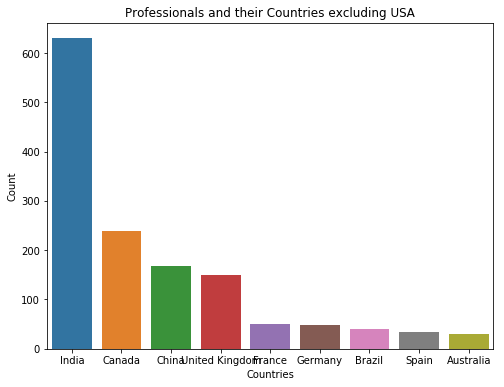

In [148]:
heros_country_val_cnt = heros_country['country'].value_counts()[1:10]

plt.figure(figsize=(8,6))
sns.barplot(heros_country_val_cnt.index, 
            heros_country_val_cnt.values)
plt.title('Professionals and their Countries excluding USA')
plt.ylabel('Count')
plt.xlabel('Countries')
plt.show()

Excluding USA, which has around 14,000 professionals, we observe how the professionals come from other countries too!

In [149]:
usa_students, etc_students = location_to_country(students, 'students_location', 'students_id')

students_country = pd.concat([usa_students, etc_students])

students_country.head()

,students_id,country
59,9658267bc2564a85bad1e802de5fb597,USA
78,d49795757f274dd690bdce3936edea20,USA
97,fae3c431698a418882c4204e5f3ee244,USA
104,2e67080928c74a4d863b2bcc60921152,USA
124,94f41c4228e2452aa8ddf786d02b06c0,USA


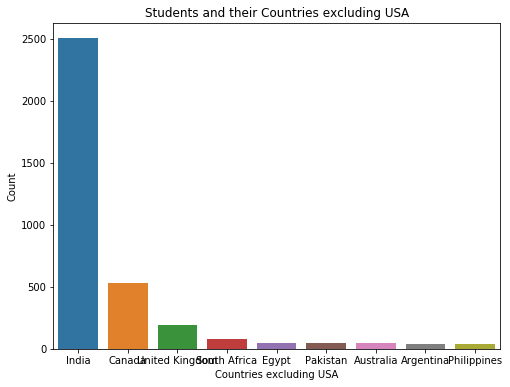

In [150]:
students_country_val_cnt = students_country['country'].value_counts()[1:10]

plt.figure(figsize=(8,6))
sns.barplot(students_country_val_cnt.index, 
            students_country_val_cnt.values)
plt.title('Students and their Countries excluding USA')
plt.ylabel('Count')
plt.xlabel('Countries excluding USA')
plt.show()

Same goes for students. Many of them come from India and they might be asking questions specific to their country. Let's create a model that takes this into account.

## 5.2 Answer scores
This could be an approach to determine quality of answers and professional's reputation.

In [151]:
questions, answers = new_question_answers()

qa = merging(questions, answers, 'questions_id', 'answers_question_id')

qa_ans_scores = merging(qa, answer_scores, 'answers_id', 'id')

qa_ans_scores.head().T

,0,1,2,3,4
questions_id,332a511f1569444485cf7a7a556a5e54,eb80205482e4424cad8f16bc25aa2d9c,eb80205482e4424cad8f16bc25aa2d9c,4ec31632938a40b98909416bdd0decff,2f6a9a99d9b24e5baa50d40d0ba50a75
questions_author_id,8f6f374ffd834d258ab69d376dd998f5,acccbda28edd4362ab03fb8b6fd2d67b,acccbda28edd4362ab03fb8b6fd2d67b,f2c179a563024ccc927399ce529094b5,2c30ffba444e40eabb4583b55233a5a4
questions_date_added,2016-04-26 11:14:26 UTC+0000,2016-05-20 16:48:25 UTC+0000,2016-05-20 16:48:25 UTC+0000,2017-02-08 19:13:38 UTC+0000,2017-09-01 14:05:32 UTC+0000
questions_title,Teacher career question,I want to become an army officer. What can I d...,I want to become an army officer. What can I d...,Will going abroad for your first job increase ...,To become a specialist in business management...
questions_body,What is a maths teacher? what is a ma...,I am Priyanka from Bangalore . Now am in 10th ...,I am Priyanka from Bangalore . Now am in 10th ...,I'm planning on going abroad for my first job....,i hear business management is a hard way to ge...
answers_id,4e5f01128cae4f6d8fd697cec5dca60c,ada720538c014e9b8a6dceed09385ee3,eaa66ef919bc408ab5296237440e323f,1a6b3749d391486c9e371fbd1e605014,5229c514000446d582050f89ebd4e184
answers_author_id,36ff3b3666df400f956f8335cf53e09e,2aa47af241bf42a4b874c453f0381bd4,cbd8f30613a849bf918aed5c010340be,7e72a630c303442ba92ff00e8ea451df,17802d94699140b0a0d2995f30c034c6
answers_question_id,332a511f1569444485cf7a7a556a5e54,eb80205482e4424cad8f16bc25aa2d9c,eb80205482e4424cad8f16bc25aa2d9c,4ec31632938a40b98909416bdd0decff,2f6a9a99d9b24e5baa50d40d0ba50a75
answers_date_added,2016-04-29 19:40:14 UTC+0000,2018-05-01 14:19:08 UTC+0000,2018-05-02 02:41:02 UTC+0000,2017-05-10 19:00:47 UTC+0000,2017-10-13 22:07:33 UTC+0000
answers_body,<p>Hi!</p>\n<p>You are asking a very interesti...,<p>Hi. I joined the Army after I attended coll...,"<p>Dear Priyanka,</p><p>Greetings! I have answ...",<p>I work for a global company who values high...,I agree with Denise. Every single job I've had...


In [152]:
p_hearts = pd.DataFrame(qa_ans_scores.groupby('answers_author_id')['score'].sum()).reset_index()

p_hearts.sort_values('score', ascending=False).head()

,answers_author_id,score
6302,a1006e6a58a0447592e2435caa230f78,449
2141,36ff3b3666df400f956f8335cf53e09e,431
194,05444a2f42454327b2ac4b463c0adbe0,338
6541,a6d33c38902546849c36ea7e9e9f0870,333
7444,be5d23056fcb4f1287c823beec5291e1,283


## 5.3 Timeliness

As mentioned, timeliness is also an important metric to CareerVillage.

In [0]:
questions, answers = new_question_answers()

mat_ema = merging(matches, emails, 'matches_email_id', 'emails_id')

que_mat_ema = merging(mat_ema, questions, 'matches_question_id', 'questions_id')

ans_que_mat_ema = merging(que_mat_ema, answers, 'questions_id', 'answers_question_id')

ema_ans_pair = ans_que_mat_ema[ans_que_mat_ema['emails_recipient_id'] == ans_que_mat_ema['answers_author_id']]

del ans_que_mat_ema; del mat_ema; del que_mat_ema; _ = gc.collect()

In [154]:
ema_ans_pair = ema_ans_pair[['questions_id', 'questions_date_added', 
                             'emails_date_sent', 
                             'answers_date_added', 'answers_author_id']]

ema_ans_pair['questions_date_added'] = pd.to_datetime(ema_ans_pair['questions_date_added']).dt.date
ema_ans_pair['emails_date_sent'] = pd.to_datetime(ema_ans_pair['emails_date_sent']).dt.date
ema_ans_pair['answers_date_added'] = pd.to_datetime(ema_ans_pair['answers_date_added']).dt.date

ema_ans_pair['resp_time'] = ema_ans_pair['answers_date_added'] - ema_ans_pair['emails_date_sent']

ema_ans_pair['resp_time'] = ema_ans_pair['resp_time'].dt.days

ema_ans_pair.head()

,questions_id,questions_date_added,emails_date_sent,answers_date_added,answers_author_id,resp_time
168,332a511f1569444485cf7a7a556a5e54,2016-04-26,2016-04-26,2016-04-29,36ff3b3666df400f956f8335cf53e09e,3
1502,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2018-02-24,2018-02-26,e58426cac810497db54359a6f60dfd53,2
1576,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2017-10-17,2017-10-17,659eb632ed6f474cb049c5da5780be58,0
1620,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2017-10-16,2017-10-17,8fa5d60da932410d9ca00f50634e6c17,1
2304,e65d17acfc6b49b292f2aed60885eaae,2016-08-12,2017-05-13,2017-05-13,a89a9b974d3c467484a398b7d4a34e61,0


In [155]:
ema_ans_pair[ema_ans_pair['answers_date_added'] < ema_ans_pair['emails_date_sent']].shape

(36, 6)

Interestingly, there are 36 instances of targeted professionals receiving the emails of questions they have already answered. It would be great if CareerVillage can handle such cases of prevent sending targeted professionals who have answered the question.

For the sake of analysis and providing a recommendation, I will convert the aforementioned professionals' `resp_time` to 0.

Subsequently, I will apply a negative exponential function to the `resp_time`. Logically, professionals who have a shorter response time should have a higher score.

In [156]:
ema_ans_pair.loc[ema_ans_pair['resp_time'] < 0, 'resp_time'] = 0

ema_ans_pair['resp_score'] = np.exp(-0.1 * ema_ans_pair['resp_time'])

ema_ans_pair['cnt'] = 1

ema_ans_pair.head()

,questions_id,questions_date_added,emails_date_sent,answers_date_added,answers_author_id,resp_time,resp_score,cnt
168,332a511f1569444485cf7a7a556a5e54,2016-04-26,2016-04-26,2016-04-29,36ff3b3666df400f956f8335cf53e09e,3,0.740818,1
1502,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2018-02-24,2018-02-26,e58426cac810497db54359a6f60dfd53,2,0.818731,1
1576,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2017-10-17,2017-10-17,659eb632ed6f474cb049c5da5780be58,0,1.000000,1
1620,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2017-10-16,2017-10-17,8fa5d60da932410d9ca00f50634e6c17,1,0.904837,1
2304,e65d17acfc6b49b292f2aed60885eaae,2016-08-12,2017-05-13,2017-05-13,a89a9b974d3c467484a398b7d4a34e61,0,1.000000,1


I propose a formula to calculate `time_score`, which is 
$$time\; score = ((2.5 \times exp\;(-0.04 \times number\; of\; questions\; answered\; so\; far) + 0.5) \times response\; score$$

This formula accounts for the notion of "beginner's bonus" in the score. Hence, I designed a rewarding mechanism that gives high bonuses to professionals when they are freshcomers but lesser as they answer more questions. Eventually, this boils down to their timeliness. This allows for comparison between professionals who answer 100 questions and take 10 days to answer each question and professionals who answer 10 questions and take 1 day to answer each question - the more timely professional.

The number 2.5 and -0.04 are hyperparameters that can be tuned. They correspond to what the initial bonus is and how quickly the bonus decreases as the user answers more questions.
The offset 0.5 is used because the mutlipler should eventually approach the value 0.5 as the number of questions answered by a professional approaches infinity.

In [157]:
ema_ans_pair['cum'] = ema_ans_pair.groupby('answers_author_id')['cnt'].cumsum()

ema_ans_pair['cum'] = ema_ans_pair['cum'] - 1

ema_ans_pair['time_score'] = ((2.5 * np.exp(-0.04 * ema_ans_pair['cum']) + 0.5) * ema_ans_pair['resp_score'])

ema_ans_pair.head()

,questions_id,questions_date_added,emails_date_sent,answers_date_added,answers_author_id,resp_time,resp_score,cnt,cum,time_score
168,332a511f1569444485cf7a7a556a5e54,2016-04-26,2016-04-26,2016-04-29,36ff3b3666df400f956f8335cf53e09e,3,0.740818,1,0,2.222455
1502,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2018-02-24,2018-02-26,e58426cac810497db54359a6f60dfd53,2,0.818731,1,0,2.456192
1576,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2017-10-17,2017-10-17,659eb632ed6f474cb049c5da5780be58,0,1.000000,1,0,3.000000
1620,c26ddf71420f48bfbf06622ebd2561a2,2016-05-18,2017-10-16,2017-10-17,8fa5d60da932410d9ca00f50634e6c17,1,0.904837,1,0,2.714512
2304,e65d17acfc6b49b292f2aed60885eaae,2016-08-12,2017-05-13,2017-05-13,a89a9b974d3c467484a398b7d4a34e61,0,1.000000,1,0,3.000000


I then take the sum of the `time_score` for each professional and apply a `log` so it does not skew too much to professionals who have answered many questions.

In [0]:
p_resp_score = pd.DataFrame(ema_ans_pair.groupby('answers_author_id')['time_score'].sum().sort_values(ascending=False)).reset_index() # 36ff3b3666df400f956f8335cf53e09e	

p_resp_score['time_score'] = np.log1p(p_resp_score['time_score'])

In [0]:
top_5 = p_resp_score.iloc[4]['answers_author_id'] # 00271cc10e0245fba4a35e76e669c281
top_701 = p_resp_score.iloc[700]['answers_author_id'] # b0de856bbbfc431794f6f0b4088d4d31

Let's compare the response time for both the 5th professional and the 701st professional.

In [160]:
print('average response time: {:.3f} days'.format(ema_ans_pair[ema_ans_pair['answers_author_id'] == top_5]['resp_time'].mean()))
ema_ans_pair[ema_ans_pair['answers_author_id'] == top_5][['emails_date_sent', 'answers_date_added', 
                                                          'resp_time', 'time_score']].copy().head()

average response time: 1.023 days


,emails_date_sent,answers_date_added,resp_time,time_score
117043,2016-10-14,2016-10-15,1,2.714512
324531,2016-12-18,2016-12-19,1,2.625814
727224,2017-09-02,2017-09-02,0,2.807791
788709,2018-04-13,2018-04-15,2,2.224738
886156,2018-03-02,2018-03-03,1,2.380048


In [161]:
print('average response time: {:.3f} days'.format(ema_ans_pair[ema_ans_pair['answers_author_id'] == top_701]['resp_time'].mean()))
ema_ans_pair[ema_ans_pair['answers_author_id'] == top_701][['emails_date_sent', 'answers_date_added', 
                                                          'resp_time', 'time_score']].copy().head()

average response time: 9.625 days


,emails_date_sent,answers_date_added,resp_time,time_score
68617,2017-09-02,2017-09-16,14,0.739791
466311,2017-06-08,2017-06-08,0,2.901974
685942,2017-09-03,2017-09-16,13,0.765212
1768907,2017-09-01,2017-09-16,15,0.606312
3633257,2017-04-10,2017-04-11,1,2.380048


As seen above, the 5th ranked professional answered almost all emails in the first 2 days while the 701st professional has a response time of more than 12 days out of the 5 entries shown above.

Conclusion: The higher the `time_score`, the more the RecSys should "bump" the professional into answering an incoming question via email.

## 5.4 Previous interactions

In [0]:
questions, answers = new_question_answers()

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])
questions['questions_date_added']  = pd.DatetimeIndex([i.replace(tzinfo=None) for i in questions['questions_date_added'] ])

questions = questions[questions['questions_date_added'] >= pd.datetime(2018,1,1)]

qa = merging(questions, answers, 'questions_id', 'answers_question_id')

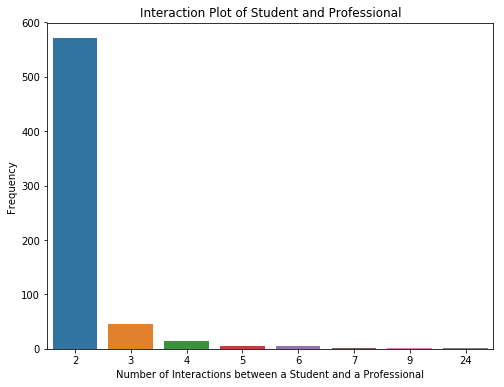

2     571
3      46
4      14
5       6
6       5
24      1
9       1
7       1
Name: interact_cnt, dtype: int64

In [164]:
qa['interact_cnt'] = 1

student_p_interact = qa.groupby(['questions_author_id', 'answers_author_id'])['interact_cnt'].sum().reset_index()

interacted_before = student_p_interact[student_p_interact['interact_cnt'] > 1]

plt.figure(figsize=(8,6))
plt.title('Interaction Plot of Student and Professional')
plt.xlabel('Number of Interactions between a Student and a Professional')
plt.ylabel('Frequency')
sns.barplot(interacted_before['interact_cnt'].value_counts().index,
            interacted_before['interact_cnt'].value_counts().values)
plt.show()

interacted_before['interact_cnt'].value_counts()

Knowing the previous interactions will not be very beneficial in recommending questions given there are many 1-time and 2-time interactions. 

# 6. Meta-RecSys
In the final section, I demonstrate a meta RecSys that takes into account metadata while recommending questions. In sum, four components (with weights assigned) will be taken into account while recommending questions.

* Ranking: 2.5 
> Ranking is an important factor as it accounts for similarity between questions and how likely professionals are able to answer.
* Timeliness: 2
> Timeliness is the next important metric since we want quetions to be answered ASAP.
* Heart_score: 0.75
> Hearts score serves as a proxy for quality of answers.
* Location: 5
>As seen in the EDA section, most questions that are unanswered or have slow responses are country-specific, hence, a much higher weight is assigned to the `location` component. 

In [0]:
def time_score(questions, matches, emails, answers, p_ids):    
    mat_ema = merging(matches, emails, 'matches_email_id', 'emails_id')

    que_mat_ema = merging(mat_ema, questions, 'matches_question_id', 'questions_id')

    ans_que_mat_ema = merging(que_mat_ema, answers, 'questions_id', 'answers_question_id')

    ema_ans_pair = ans_que_mat_ema[ans_que_mat_ema['emails_recipient_id'] == ans_que_mat_ema['answers_author_id']]

    del ans_que_mat_ema; del mat_ema; del que_mat_ema; _ = gc.collect()
    
    ema_ans_pair = ema_ans_pair[['questions_id', 'questions_date_added', 
                             'emails_date_sent', 
                             'answers_date_added', 'answers_author_id']].copy()
    
    # construct time score only for p_ids
    ema_ans_pair = ema_ans_pair[ema_ans_pair['answers_author_id'].isin(p_ids)]

    ema_ans_pair['questions_date_added'] = pd.to_datetime(ema_ans_pair['questions_date_added']).dt.date
    ema_ans_pair['emails_date_sent'] = pd.to_datetime(ema_ans_pair['emails_date_sent']).dt.date
    ema_ans_pair['answers_date_added'] = pd.to_datetime(ema_ans_pair['answers_date_added']).dt.date

    ema_ans_pair['resp_time'] = ema_ans_pair['answers_date_added'] - ema_ans_pair['emails_date_sent']

    ema_ans_pair['resp_time'] = ema_ans_pair['resp_time'].dt.days

    ema_ans_pair.loc[ema_ans_pair['resp_time'] < 0, 'resp_time'] = 0

    ema_ans_pair['resp_score'] = np.exp(-0.1 * ema_ans_pair['resp_time'])

    ema_ans_pair['cnt'] = 1
    
    ema_ans_pair['cum'] = ema_ans_pair.groupby('answers_author_id')['cnt'].cumsum()

    ema_ans_pair['cum'] = ema_ans_pair['cum'] - 1

    ema_ans_pair['time_score'] = ((2.5 * np.exp(-0.04 * ema_ans_pair['cum']) + 0.5) * ema_ans_pair['resp_score'])

    p_resp_score = pd.DataFrame(ema_ans_pair.groupby('answers_author_id')['time_score'].sum().sort_values(ascending=False)).reset_index() # 36ff3b3666df400f956f8335cf53e09e	

    p_resp_score['time_score'] = np.log1p(p_resp_score['time_score'])

    return p_resp_score

In [0]:
def hearts_score(qa, answer_scores, p_ids):
    qa_ans_scores = merging(qa, answer_scores, 'answers_id', 'id')
    
    qa_ans_scores = qa_ans_scores[qa_ans_scores['answers_author_id'].isin(p_ids)]
    
    p_hearts = pd.DataFrame(qa_ans_scores.groupby('answers_author_id')['score'].sum()).reset_index()
    
    p_hearts = p_hearts.rename(columns={'score': 'hearts_score'})

    return p_hearts

In [0]:
def location_score(student_location, p_ids):
    select_p = professionals[professionals['professionals_id'].isin(p_ids)]
    
    usa_heros, etc_heros = location_to_country(select_p, 'professionals_location', 'professionals_id')
    
    heros_country = pd.concat([usa_heros, etc_heros])

    # if student and professionals are from USA, give score of 1
    # if student is from USA but professionals are not, give score of 0.8    
    if student_location == 'USA':
        heros_country.loc[(heros_country['country'] == student_location), 'country_score'] = 1
        heros_country.loc[(heros_country['country'] != student_location), 'country_score'] = 0.8
        
    # if student and professionals are from the same country but not USA, give score of 5
    # if student is not from USA but professionals are from USA, give score of 0.5
    else:
        heros_country.loc[(heros_country['country'] == student_location), 'country_score'] = 5
        heros_country.loc[(heros_country['country'] != student_location), 'country_score'] = 0.5

    return heros_country

In [0]:
def build_run_RecSys(query, questions, s, ans, qa, p_ids):
    
    tfidf, tfidf_matrix, fscl, femb, gscl, gemb, ans_tf, fans_scl, gans_scl, t_p_scores, f_p_scores, g_p_scores, VOCAB = build_RecSys(s, ans, qa, p_ids)
    
    recommended_p = run_RecSys(query, questions, qa, 10, 
                               tfidf, tfidf_matrix, 
                               fscl, femb, 
                               gscl, gemb, 
                               ans_tf, fans_scl, gans_scl, 
                               t_p_scores, f_p_scores, g_p_scores)
    
    return recommended_p

Perform experiment on a small sample, i.e., first 1000 rows.

In [0]:
questions, answers = new_question_answers()

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])

questions = questions[:1000]

qa = merging(questions, answers, 'questions_id', 'answers_question_id')

questions['questions_title_body'] = questions['questions_title'] + \
                                    str(' ') + \
                                    questions['questions_body']

s = process_text(questions, 'questions_title_body').values

ans = process_text(qa, 'answers_body').values

p_ids = qa['answers_author_id'].unique().tolist()

In [0]:
def meta_RecSys(top_10_ps, time_score_df, answers_score_df, location_score_df, professionals):
    top_10_ps_df = pd.DataFrame({'professionals_id': top_10_ps,
                                 'reciprocal_rank': list(np.linspace(10, 1, 10))})
    
    professionals = professionals[professionals['professionals_id'].isin(top_10_ps)][['professionals_id',
                                                                                      'professionals_headline']]
    
    final_df = top_10_ps_df.merge(time_score_df, left_on='professionals_id',
                                  right_on='answers_author_id', how='outer')

    final_df.drop('answers_author_id', axis=1, inplace=True)

    final_df = final_df.merge(answers_score_df, left_on='professionals_id',
                              right_on='answers_author_id', how='outer')

    final_df.drop('answers_author_id', axis=1, inplace=True)
    
    final_df = final_df.merge(location_score_df, left_on='professionals_id',
                              right_on='professionals_id', how='outer')

    final_df.drop('country', axis=1, inplace=True)

    final_df = final_df.fillna(0)
    
    # some hyperparamters to tune
    RANK_WEIGHT = 2.5
    TIME_WEIGHT = 2
    SCORE_WEIGHT = 0.75
    LOCATION_WEIGHT = 5
    
    final_df['meta_score'] = RANK_WEIGHT * final_df['reciprocal_rank'] + \
                             TIME_WEIGHT * final_df['time_score'] + \
                             SCORE_WEIGHT * final_df['hearts_score'] + \
                             LOCATION_WEIGHT * final_df['country_score']
    
    final_df = final_df.merge(professionals, left_on='professionals_id',
                              right_on='professionals_id', how='outer')

    
    final_df = final_df.sort_values('meta_score', ascending=False)
    
    return final_df

In [171]:
query = 'I am interested in machine learning and want to be a data scientist one day. i heard artificial intelligence is cool'
query_country = 'USA'

top_10_ps = build_run_RecSys(query, questions, s, ans, qa, p_ids)
time_score_df = time_score(questions, matches, emails, answers, top_10_ps)
hearts_score_df = hearts_score(qa, answer_scores, top_10_ps)
location_df = location_score(query_country, top_10_ps)

meta_RecSys(top_10_ps, time_score_df, hearts_score_df, location_df, professionals)

,professionals_id,reciprocal_rank,time_score,hearts_score,country_score,meta_score,professionals_headline
0,3ea0910f146e4bc1b0da625d49da320c,10.0,1.312247,2,1.0,34.124495,Business Intelligence Manager
5,58fa5e95fe9e480a9349bbb1d7faaddb,5.0,1.312247,11,1.0,28.374495,Mechanical Engineer I Automotive
3,e6cc3bb515044e919544bb4cb479944e,7.0,1.036592,1,1.0,25.323184,Data Scientist at Airbnb
1,3daa962dd713439eaf6df9e2966d9514,9.0,0.000000,0,0.0,22.500000,Student at California State University-Los Ang...
2,243c51ebbd71471d9af55cc34ce305e0,8.0,0.000000,1,0.0,20.750000,NaN
6,a1006e6a58a0447592e2435caa230f78,4.0,0.000000,7,0.8,19.250000,Educational Writer- New Heights Educational Group
4,d2a6707d22af41acabe8cbc377c8fb23,6.0,1.386294,0,0.0,17.772589,IT Consultant
7,c24c29c966e1431bbaa36bc900457cc2,3.0,1.386294,0,1.0,15.272589,Mechanical/Manufacturing Engineer
9,a8d48ad29465479bbeb7f19ee3b77d1a,1.0,0.000000,1,0.8,7.250000,Escalation Specialist at Dell
8,2801dfbdd5914b65b3369ff3385bc16b,2.0,0.000000,0,0.0,5.000000,Now available!All-rounder Mechanical Engineer ...


As seen above, each professional now has a `meta_score`, we are left with 2 options to recommend a question:
* Recommend questions to top 5 professionals according to the `meta_score`
* Select a cutoff for `meta_score` while recommending questions to professionals

I think both approaches will work well and it is left to CareerVillage to do A/B testing on which is the better approach.

# 7. Final Meta-RecSys
In the following, I select a test sample from 2018/3/1 to 2018/3/31 and validate the effectiveness of the RecSys on 2018/4/1 to 2018/4/4.

To recap, here is the final meta-RecSys! ![](https://imgur.com/SbUsWSt.png)

In [0]:
questions, answers = new_question_answers()

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'])
questions['questions_date_added']  = pd.DatetimeIndex([i.replace(tzinfo=None) for i in questions['questions_date_added'] ])

TRAIN_questions = questions[(questions['questions_date_added'] >= pd.datetime(2018, 3, 1)) &
                            (questions['questions_date_added'] < pd.datetime(2018, 4, 1))].reset_index()

VAL_questions = questions[(questions['questions_date_added'] >= pd.datetime(2018, 4, 1)) &
                          (questions['questions_date_added'] < pd.datetime(2018, 4, 3))].reset_index()

questions_d1 = questions[(questions['questions_date_added'] >= pd.datetime(2018, 4, 1)) &
                         (questions['questions_date_added'] < pd.datetime(2018, 4, 2))]

questions_d2 = questions[(questions['questions_date_added'] >= pd.datetime(2018, 4, 2)) &
                         (questions['questions_date_added'] < pd.datetime(2018, 4, 3))]

questions_d1.shape , questions_d2.shape

TRAIN_questions['questions_title_body'] = TRAIN_questions['questions_title'] + \
                                          str(' ') + \
                                          TRAIN_questions['questions_body']

s = process_text(TRAIN_questions, 'questions_title_body').values

TRAIN_qa = merging(TRAIN_questions, answers, 'questions_id', 'answers_question_id')

ans = process_text(TRAIN_qa, 'answers_body').values

p_ids = TRAIN_qa['answers_author_id'].unique().tolist()

# preprocess students location
select_students = students[students['students_id'].isin(VAL_questions['questions_author_id'])]

usa_students, etc_students = location_to_country(select_students, 'students_location', 'students_id')

students_country = pd.concat([usa_students, etc_students])

In [173]:
print('Number of professionals in the period: {}'.format(len(p_ids))) 
print('Number of questions in the period: {}'.format(s.shape[0])) 
print('Number of answers in the period: {}'.format(ans.shape[0])) 
print('Number of answers in day 1: {}'.format(questions_d1.shape[0])) 
print('Number of answers in day 2: {}'.format(questions_d2.shape[0])) 

Number of professionals in the period: 934
Number of questions in the period: 915
Number of answers in the period: 1761
Number of answers in day 1: 4
Number of answers in day 2: 14


In [0]:
np.random.seed(seed=42)

daily_noti = list(np.random.choice([0, 1], len(p_ids), replace=True))

noti_freq = pd.DataFrame({'professionals_id': p_ids,
                          'daily_noti': daily_noti})

noti_freq.head()

daily_p = noti_freq[noti_freq['daily_noti'] == 1].index.tolist()
three_d_p = noti_freq[noti_freq['daily_noti'] == 0].index.tolist()

In [175]:
%%time
tfidf, tfidf_matrix, fscl, femb, gscl, gemb, ans_tf, fans_scl, gans_scl, t_p_scores, f_p_scores, g_p_scores, VOCAB = build_RecSys(s, ans, TRAIN_qa, p_ids)

CPU times: user 4.98 s, sys: 351 ms, total: 5.33 s
Wall time: 4.87 s


In [0]:
def updated_assign(df, qa, questions, dont_ask):
    df['questions_title_body'] = df['questions_title'] + \
                                 str(' ') + \
                                 df['questions_body']
    
    pid_qid_match = [[] for i in range(len(p_ids))]
    
    skip = []
    for k, v in df.iterrows():
        query = v['questions_title_body']
        qid = v['questions_id']        
        query_coutry = (students_country[students_country['students_id'] == v['questions_author_id']]['country']).tolist()[0]
        
        # get top 10 professionals
        top_10_ps = run_RecSys(query, questions, qa, 10, 
                               tfidf, tfidf_matrix, 
                               fscl, femb, 
                               gscl, gemb, 
                               ans_tf, fans_scl, gans_scl, 
                               t_p_scores, f_p_scores, g_p_scores)
        
        # calculate their time_score
        time_score_df = time_score(questions, matches, emails, answers, top_10_ps)
        
        # calculate their hearts score
        hearts_score_df = hearts_score(qa, answer_scores, top_10_ps)
        
        # calculate location score
        location_df = location_score(query_country, top_10_ps)

        # meta_RecSys df
        recommended_p = meta_RecSys(top_10_ps, time_score_df, hearts_score_df, location_df, professionals)
        
        recommended_p_list = recommended_p['professionals_id'].tolist()
        
        # start assigning professionals to each question
        cnt = 0
        for pid in recommended_p_list:    
            
            # if the question has been assigned to 5 professionals, 
            # stop
            if cnt >= 5: 
                break
            
            # get professional_id's idx
            p_idx = p_ids.index(pid)
            
            # if professionals received more than 5 questions,
            # stop assigning
            if p_idx not in dont_ask:
                if len(pid_qid_match[p_idx]) < 5:                    
                    pid_qid_match[p_idx].append(qid)
                    cnt += 1
                    
            # if professionals signed up for 3-day noti
            # add them to skip
            if p_idx in three_d_p and p_idx not in skip:
                skip.append(p_idx)
        
        # add professionals we want to skip
        # to dont_ask
        for p_idx in skip:
            dont_ask.append(p_idx)
            
    return pid_qid_match, dont_ask

I will be running the meta RecSys with questions for 2 days as an illustration.

In [0]:
dont_ask = []
match_d1, dont_ask = updated_assign(questions_d1, TRAIN_qa, TRAIN_questions, dont_ask)
match_d2, dont_ask = updated_assign(questions_d2, TRAIN_qa, TRAIN_questions, dont_ask)

In [178]:
noti_freq['d1'] = pd.Series((v for v in match_d1)) 
noti_freq['d2'] = pd.Series((v for v in match_d2)) 

noti_freq.head()

,professionals_id,daily_noti,d1,d2
0,714f9104e8b148c090e975f050946ff2,0,[],[]
1,5fb15f468af546bbbf7861b0025b947d,1,[],[]
2,a4de076b955d410896bdbf7a986ccc38,0,[],[492d6767e2f248e6bfd709a4cc71ea22]
3,5285b0a21ab54d7ab94a9ab1589bd536,0,[],[]
4,8fc23e1bbb2a4ec1bc780e77d118ecf3,0,[],[492d6767e2f248e6bfd709a4cc71ea22]


# 8. Conclusion
I asked Jared what is a good recommender system in his opinion. He mentioned:

`percent of questions which get a 10-quality-point answer within 24 hours, without churning out Pros, and within the bounds of fairness?`

My solution:
* `Percent of questions...`
> The recommender system has been targeting professionals fairly accurately in the Evaluation section above.
* `...receiving a...`
> Assuming the recommender system is able to target 5 professionals per question, this should be relatively easy to solve.
* `...10-quality-point answer...`
> The recommender system uses `hearts_score` as a proxy of quality answers.
* `...within 24 hours,...`
> The recommender system takes into account professionals' timeliness in responding to an answer and also provides a `bonus` to freshcomers (as a way of handling the cold-start problem).
* `...without churning out Pros...`
> The recommender system considers professionals' notification setting - limits email to "superstar" professionals and sends email regularly to "marginal" professionals to keep them engaged.
* `...and within the bounds of fairness.`
> The recommender system does not account for the students' background other than their location. The location information is helpful for the international community. 

# 9. Final Thoughts
* Did you decide to predict Pros given a Question, or predict Questions given a Pro? Why?
> The final meta-RecSys will initially recommend a Pro given a Question but will also recommend Questions given a Pro if the Pro is not matched for 3 days (Recommendation #4). The former approach is more efficient to get high quality matches and the latter approach is to keep Pros engaged within the platform.

* Does your model address the "cold start" problem for Professionals who just signed up but have not yet answered any questions? How'd you approach that challenge?
> I suggested Pros who just signed up to follow some tags. The RecSys will then be able to capture similar Pros who are related to the tags and recommend them to the freshers (Recommendation #5). Additionally, my `time_score` also accounts for freshers by giving them a bonus (Metadata 5.3).

* Did your model have any novel approaches to ensuring that "no question gets left behind"?
> Each questions is targeted with 5 professionals (Final meta-RecSys). I also proposed to keep track of questions that are unanswered and recommend professionals based on login session (Recommendation #6).

* What types of models did you try, and why did you pick the model architecture that you picked?
> TF-IDF, FastText, GloVe, and Universal Sentence Encoder - 4 models are used to look for similar questions and answers profile. They capture words similarity and semantics differently. I currently use an equal weght for each of them while doing a Borda count (Evalation approach #1).

* Did you engineer any new data features? Which ones worked well for your model?
> Location score, time score, and hearts score are taken into account for the meta-RecSys (Metadata).

* Is there anything built into your approach to protect certain Professionals from being "overburdened" with a disproportionately high share of matches?
> The meta-RecSys limits recommending a Pro who have more than 5 matches a day. It can be further extended to not match a Pro who has received emails consecutively for few days (Recommendation #2).

* What do you wish you could use in the future (that perhaps we could try out on our own as an extension of your work)?
> Allowing Pros to update their profiles is my biggest hope! This is crucial as Pros are able to help our RecSys to recommend higher quality content or content they are interested in (Recommendation #1).

# 10. Closing remarks
I would like to express my gratitude to Kaggle and CareerVillage for presenting such an interesting problem before us. For those have shared their kernel, I learned a tremendous amount from how all of you perform remarkable EDA that I never have of thought. I worked on this out of interest - knowing that I was once in the shoes of all those students, I wanted to help them. I always imagine how nice would if be if I were able to receive career advice on an earlier point in my life. All the best to CareerVillage. I sincerely hope they continue this initiative and more students will benefit from this amazing platform.